In [1]:
!pip install pmdarima -q
!pip install arch -q
!pip install -U shap -q
!pip install prophet -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-core 0.1.0b20210210 requires numpy==1.19, but you have numpy 1.19.5 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


In [2]:
# Base 
# -----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import xgboost as xgb

# Missing Value
# -----------------------------------
import missingno as msno

# Configuration
# -----------------------------------
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

from termcolor import colored

In [3]:
# Import
aq_petrignago = pd.read_csv("../input/acea-water-prediction/Aquifer_Petrignano.csv")
aq_petrignago.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5223 entries, 0 to 5222
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Date                                  5223 non-null   object 
 1   Rainfall_Bastia_Umbra                 4199 non-null   float64
 2   Depth_to_Groundwater_P24              5168 non-null   float64
 3   Depth_to_Groundwater_P25              5184 non-null   float64
 4   Temperature_Bastia_Umbra              4199 non-null   float64
 5   Temperature_Petrignano                4199 non-null   float64
 6   Volume_C10_Petrignano                 5025 non-null   float64
 7   Hydrometry_Fiume_Chiascio_Petrignano  4199 non-null   float64
dtypes: float64(7), object(1)
memory usage: 326.6+ KB


In [4]:
features_col = list(aq_petrignago.columns)
features_col.remove('Date')
features_col.remove('Depth_to_Groundwater_P25')
features_col.append('Humidity_Class')

# Data preprocessing

Set date index

In [5]:
def set_date_index(df):
    df['Date'] = pd.to_datetime(df['Date'], format = '%d/%m/%Y')
#     df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')
    df.set_index('Date',inplace=True, drop=False)
    return df

df = set_date_index(aq_petrignago)
df = df.drop('Depth_to_Groundwater_P24', axis=1) # Remove redundant col
df['Humidity_Class'] = (df['Depth_to_Groundwater_P25']/5).round()

df.head()

Date  Rainfall_Bastia_Umbra  Depth_to_Groundwater_P25  \
Date                                                                     
2006-03-14 2006-03-14                    NaN                    -22.18   
2006-03-15 2006-03-15                    NaN                    -22.14   
2006-03-16 2006-03-16                    NaN                    -22.04   
2006-03-17 2006-03-17                    NaN                    -22.04   
2006-03-18 2006-03-18                    NaN                    -22.04   

            Temperature_Bastia_Umbra  Temperature_Petrignano  \
Date                                                           
2006-03-14                       NaN                     NaN   
2006-03-15                       NaN                     NaN   
2006-03-16                       NaN                     NaN   
2006-03-17                       NaN                     NaN   
2006-03-18                       NaN                     NaN   

            Volume_C10_Petrignano  Hydrometry_Fiume_Chiascio_Petrignano  \
Date                                                                      
2006-03-14                    NaN                                   NaN   
2006-03-15                    NaN                                   NaN   
2006-03-16                    NaN                                   NaN   
2006-03-17                    NaN                                   NaN   
2006-03-18                    NaN                                   NaN   

            Humidity_Class  
Date                        
2006-03-14           -4.00  
2006-03-15           -4.00  
2006-03-16           -4.00  
2006-03-17           -4.00  
2006-03-18           -4.00

Replacing implausible values with nan

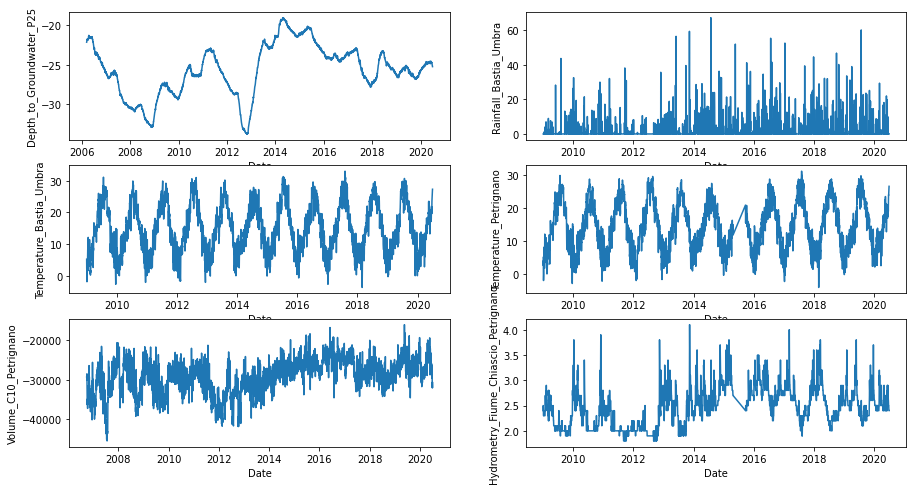

In [6]:
# Replacinmg implausible values with nan
df['Hydrometry_Fiume_Chiascio_Petrignano'] = np.where((df.Hydrometry_Fiume_Chiascio_Petrignano == 0),np.nan, df.Hydrometry_Fiume_Chiascio_Petrignano)
df['Volume_C10_Petrignano'] = np.where((df.Volume_C10_Petrignano == 0),np.nan, df.Volume_C10_Petrignano)
df['Temperature_Petrignano'] = np.where((df.Temperature_Petrignano == 0),np.nan, df.Temperature_Petrignano)

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

sns.lineplot(x=df.index, y=df.Depth_to_Groundwater_P25, ax=axes[0][0]) 
sns.lineplot(x=df.index, y=df.Rainfall_Bastia_Umbra, ax=axes[0][1]) 
sns.lineplot(x=df.index, y=df.Temperature_Bastia_Umbra, ax=axes[1][0]) 
sns.lineplot(x=df.index, y=df.Temperature_Petrignano, ax=axes[1][1]) 
sns.lineplot(x=df.index, y=df.Volume_C10_Petrignano, ax=axes[2][0]) 
sns.lineplot(x=df.index, y=df.Hydrometry_Fiume_Chiascio_Petrignano, ax=axes[2][1]) 

plt.show()

Interpolating missing values

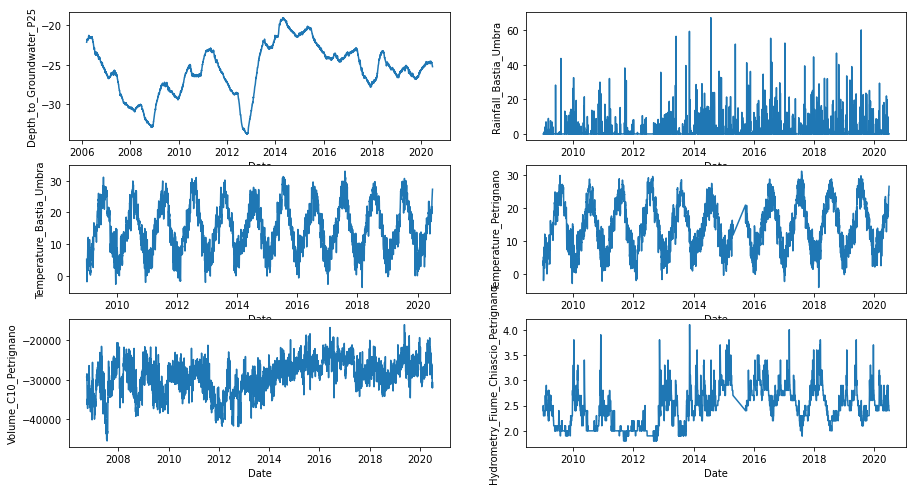

In [7]:
df['Volume_C10_Petrignano'] = df['Volume_C10_Petrignano'].interpolate()
df['Hydrometry_Fiume_Chiascio_Petrignano'] = df['Hydrometry_Fiume_Chiascio_Petrignano'].interpolate()
df['Depth_to_Groundwater_P25'] = df['Depth_to_Groundwater_P25'].interpolate()

f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

sns.lineplot(x=df.index, y=df.Depth_to_Groundwater_P25, ax=axes[0][0]) 
sns.lineplot(x=df.index, y=df.Rainfall_Bastia_Umbra, ax=axes[0][1]) 
sns.lineplot(x=df.index, y=df.Temperature_Bastia_Umbra, ax=axes[1][0]) 
sns.lineplot(x=df.index, y=df.Temperature_Petrignano, ax=axes[1][1]) 
sns.lineplot(x=df.index, y=df.Volume_C10_Petrignano, ax=axes[2][0]) 
sns.lineplot(x=df.index, y=df.Hydrometry_Fiume_Chiascio_Petrignano, ax=axes[2][1]) 

plt.show()

In [8]:


fig = make_subplots(rows=3, cols=2, subplot_titles=("Depth_to_Groundwater_P25", "Rainfall_Bastia_Umbra", "Temperature_Bastia_Umbra", "Temperature_Petrignano", "Volume_C10_Petrignano", "Hydrometry_Fiume_Chiascio_Petrignano"))

fig.add_trace(go.Line(x=df.index, y=df.Depth_to_Groundwater_P25, name="Depth_to_Groundwater_P25"),
              row=1, col=1)
        # Edit the layout
fig.add_trace(go.Line(x=df.index, y=df.Rainfall_Bastia_Umbra, name="Rainfall_Bastia_Umbra"),
              row=1, col=2)
fig.add_trace(go.Line(x=df.index, y=df.Temperature_Bastia_Umbra, name="Temperature_Bastia_Umbra"),
              row=2, col=1)
fig.add_trace(go.Line(x=df.index, y=df.Temperature_Petrignano, name="Temperature_Petrignano"),
              row=2, col=2)
fig.add_trace(go.Line(x=df.index, y=df.Volume_C10_Petrignano, name="Volume_C10_Petrignano"),
              row=3, col=1)
fig.add_trace(go.Line(x=df.index, y=df.Hydrometry_Fiume_Chiascio_Petrignano, name="Hydrometry_Fiume_Chiascio_Petrignano"),
              row=3, col=2)
fig.update_layout(showlegend=False)
fig.show()
# f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 8))

# sns.lineplot(x=df.index, y=df.Depth_to_Groundwater_P25, ax=axes[0][0]) 
# sns.lineplot(x=df.index, y=df.Rainfall_Bastia_Umbra, ax=axes[0][1]) 
# sns.lineplot(x=df.index, y=df.Temperature_Bastia_Umbra, ax=axes[1][0]) 
# sns.lineplot(x=df.index, y=df.Temperature_Petrignano, ax=axes[1][1]) 
# sns.lineplot(x=df.index, y=df.Volume_C10_Petrignano, ax=axes[2][0]) 
# sns.lineplot(x=df.index, y=df.Hydrometry_Fiume_Chiascio_Petrignano, ax=axes[2][1]) 

# plt.show()
def plot_to_html(name,fig):
    fig.write_html(name,include_plotlyjs='cdn',full_html=False)

plot_to_html("bruh.html",fig)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [9]:
fig = go.Figure(
    layout=go.Layout(
        title=go.layout.Title(text="")
    )
)

fig.add_trace(go.Line(x=df.index, y=df.Depth_to_Groundwater_P25/df.Depth_to_Groundwater_P25.mean(), name="Depth_to_Groundwater_P25"))
fig.add_trace(go.Line(x=df.index, y=df.Rainfall_Bastia_Umbra/50, name="Rainfall_Bastia_Umbra"))
fig.add_trace(go.Line(x=df.index, y=df.Temperature_Bastia_Umbra/df.Temperature_Bastia_Umbra.mean(), name="Temperature_Bastia_Umbra"))
fig.add_trace(go.Line(x=df.index, y=df.Temperature_Petrignano/df.Temperature_Petrignano.mean(), name="Temperature_Petrignano"))
fig.add_trace(go.Line(x=df.index, y=df.Volume_C10_Petrignano/df.Volume_C10_Petrignano.mean(), name="Volume_C10_Petrignano"))
fig.add_trace(go.Line(x=df.index, y=df.Hydrometry_Fiume_Chiascio_Petrignano/df.Hydrometry_Fiume_Chiascio_Petrignano.mean(), name="Hydrometry_Fiume_Chiascio_Petrignano"))
fig.update_layout(showlegend=False)
fig.show()


## Check for stationarity
constant mean and mean is not time-dependent

constant variance and variance is not time-dependent

constant covariance and covariance is not time-dependent

In [10]:
rolling_window = 52
#f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))

def stationarity_plot(X):
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    sns.lineplot(x=df.Date, y=df[X], ax=ax, color='indianred')
    sns.lineplot(x=df.Date, y=df[X].rolling(rolling_window).mean(), ax=ax, color='black', label='rolling mean')
    sns.lineplot(x=df.Date, y=df[X].rolling(rolling_window).std(), ax=ax, color='blue', label='rolling std')
    ax.set_title(X+': Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
    ax.set_ylabel(ylabel=X, fontsize=14)

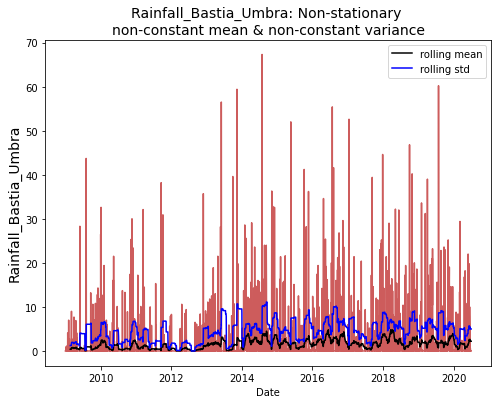

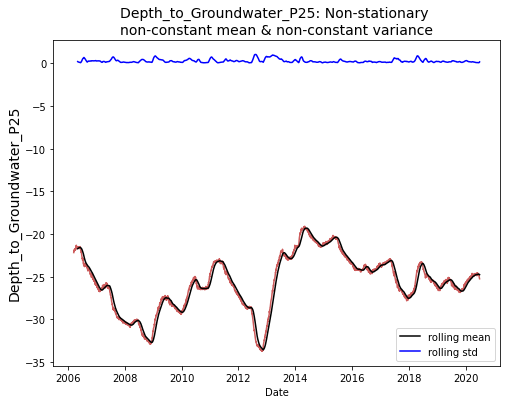

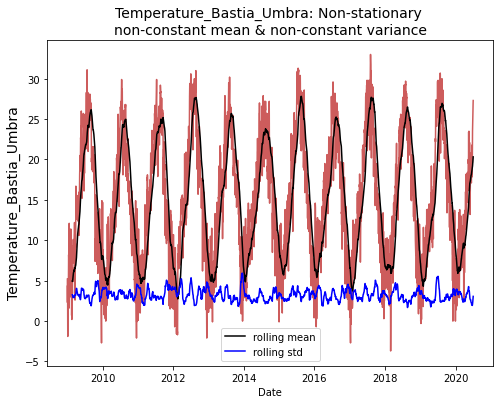

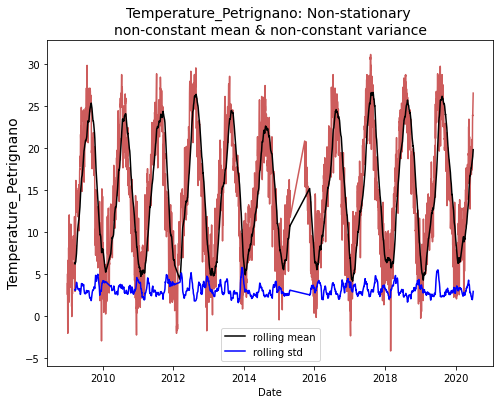

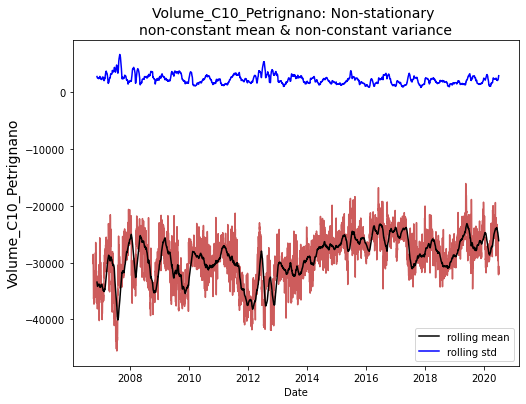

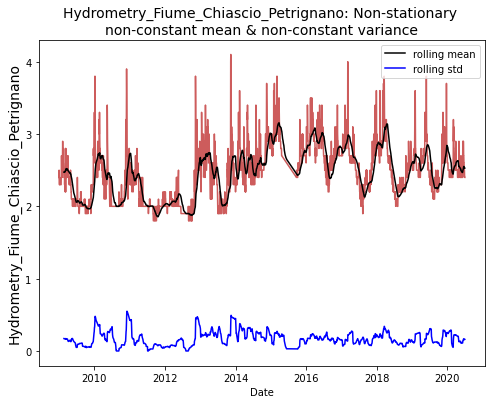

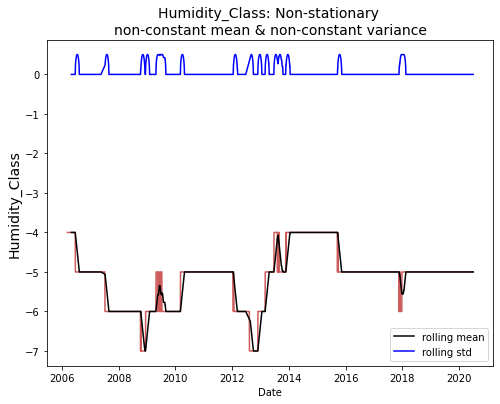

In [11]:
for i in df:
    if i != "Date":
        stationarity_plot(i)

(example) Let's do the visual check first. We can see that all features except Temperature have non-constant mean and non-constant variance. Therefore, none of these seem to be stationary. However, Temperature shows strong seasonality (hot in summer, cold in winter) and therefore it is not stationary either.


# Feature Engineering

## Time Features

In [12]:
df['year'] = pd.DatetimeIndex(df['Date']).year
df['month'] = pd.DatetimeIndex(df['Date']).month
df['day'] = pd.DatetimeIndex(df['Date']).day
df['day_of_year'] = pd.DatetimeIndex(df['Date']).dayofyear
df['week_of_year'] = pd.DatetimeIndex(df['Date']).weekofyear
df['quarter'] = pd.DatetimeIndex(df['Date']).quarter
df['season'] = df.month%12 // 3 + 1

df[['Date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()

Date  year  month  day  day_of_year  week_of_year  quarter  \
Date                                                                          
2006-03-14 2006-03-14  2006      3   14           73            11        1   
2006-03-15 2006-03-15  2006      3   15           74            11        1   
2006-03-16 2006-03-16  2006      3   16           75            11        1   
2006-03-17 2006-03-17  2006      3   17           76            11        1   
2006-03-18 2006-03-18  2006      3   18           77            11        1   

            season  
Date                
2006-03-14       2  
2006-03-15       2  
2006-03-16       2  
2006-03-17       2  
2006-03-18       2

## Encoding Cyclical Features
The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

In [13]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df.month/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df.month/month_in_year)

In [14]:
days_in_month = 30
df['day_sin'] = np.sin(2*np.pi*df.day/days_in_month)
df['day_cos'] = np.cos(2*np.pi*df.day/days_in_month)

days_in_year = 365
df['day_of_year_sin'] = np.sin(2*np.pi*df.day_of_year/days_in_year)
df['day_of_year_cos'] = np.cos(2*np.pi*df.day_of_year/days_in_year)

weeks_in_year = 52.1429
df['week_of_year_sin'] = np.sin(2*np.pi*df.week_of_year/weeks_in_year)
df['week_of_year_cos'] = np.cos(2*np.pi*df.week_of_year/weeks_in_year)

quarters_in_year = 4
df['quarter_sin'] = np.sin(2*np.pi*df.quarter/quarters_in_year)
df['quarter_cos'] = np.cos(2*np.pi*df.quarter/quarters_in_year)

seasons_in_year = 4
df['season_sin'] = np.sin(2*np.pi*df.season/seasons_in_year)
df['season_cos'] = np.cos(2*np.pi*df.season/seasons_in_year)


In [15]:
# df=df.drop(columns=["year", "month", "day", "day_of_year", "week_of_year", "quarter", "season"])

In [16]:
df_temp = df.copy()
df_temp = df_temp.drop(columns="Date")
X = df_temp.copy()

X=X.dropna()
X = X.join(X.loc[:, X.columns.isin(features_col)].pct_change(1),rsuffix="_pct")
X = X.drop('Depth_to_Groundwater_P25',axis=1)
# X = X.drop('Rainfall_Bastia_Umbra',axis=1)
#X['Rainfall'] = df['Rainfall_Bastia_Umbra']
X = X.rename(columns={"pct_Hydrometry_Fiume_Chiascio_Petrignano": "Hydrometry", "pct_Temperature_Bastia_Umbra": "Temperature_Bastia_pctchange"
                     , "pct_Temperature_Petrignano": "Temperature_Petrignano_pctchange","pct_Volume_C10_Petrignano": "Volume"})
X = X.shift(-1)

for col in X:
    X[col] = [0 if np.isnan(x) or np.isinf(x) else x for x in X[col]]

In [17]:
X

Rainfall_Bastia_Umbra  Temperature_Bastia_Umbra  \
Date                                                          
2009-01-01                   0.00                      2.30   
2009-01-02                   0.00                      4.40   
2009-01-03                   0.00                      0.80   
2009-01-04                   0.00                     -1.90   
2009-01-05                   0.00                     -0.70   
...                           ...                       ...   
2020-06-26                   0.00                     26.20   
2020-06-27                   0.00                     26.90   
2020-06-28                   0.00                     26.90   
2020-06-29                   0.00                     27.30   
2020-06-30                   0.00                      0.00   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                                                        
2009-01-01                    2.50              -28785.89   
2009-01-02                    3.90              -25766.21   
2009-01-03                    0.80              -27919.30   
2009-01-04                   -2.10              -29854.66   
2009-01-05                   -0.70              -29124.58   
...                            ...                    ...   
2020-06-26                   25.00              -31332.96   
2020-06-27                   25.70              -32120.93   
2020-06-28                   26.00              -30602.88   
2020-06-29                   26.50              -31878.14   
2020-06-30                    0.00                   0.00   

            Hydrometry_Fiume_Chiascio_Petrignano  Humidity_Class    year  \
Date                                                                       
2009-01-01                                  2.50           -6.00 2009.00   
2009-01-02                                  2.40           -6.00 2009.00   
2009-01-03                                  2.40           -6.00 2009.00   
2009-01-04                                  2.30           -6.00 2009.00   
2009-01-05                                  2.30           -6.00 2009.00   
...                                          ...             ...     ...   
2020-06-26                                  2.40           -5.00 2020.00   
2020-06-27                                  2.40           -5.00 2020.00   
2020-06-28                                  2.40           -5.00 2020.00   
2020-06-29                                  2.40           -5.00 2020.00   
2020-06-30                                  0.00            0.00    0.00   

            month   day  day_of_year  week_of_year  quarter  season  \
Date                                                                  
2009-01-01   1.00  2.00         2.00          1.00     1.00    1.00   
2009-01-02   1.00  3.00         3.00          1.00     1.00    1.00   
2009-01-03   1.00  4.00         4.00          1.00     1.00    1.00   
2009-01-04   1.00  5.00         5.00          2.00     1.00    1.00   
2009-01-05   1.00  6.00         6.00          2.00     1.00    1.00   
...           ...   ...          ...           ...      ...     ...   
2020-06-26   6.00 27.00       179.00         26.00     2.00    3.00   
2020-06-27   6.00 28.00       180.00         26.00     2.00    3.00   
2020-06-28   6.00 29.00       181.00         27.00     2.00    3.00   
2020-06-29   6.00 30.00       182.00         27.00     2.00    3.00   
2020-06-30   0.00  0.00         0.00          0.00     0.00    0.00   

            month_sin  month_cos  day_sin  day_cos  day_of_year_sin  \
Date                                                                  
2009-01-01       0.50       0.87     0.41     0.91             0.03   
2009-01-02       0.50       0.87     0.59     0.81             0.05   
2009-01-03       0.50       0.87     0.74     0.67             0.07   
2009-01-04       0.50       0.87     0.87     0.50             0.09   
2009-01-05       0.50       0.87     0.95     0.31         

<AxesSubplot:>

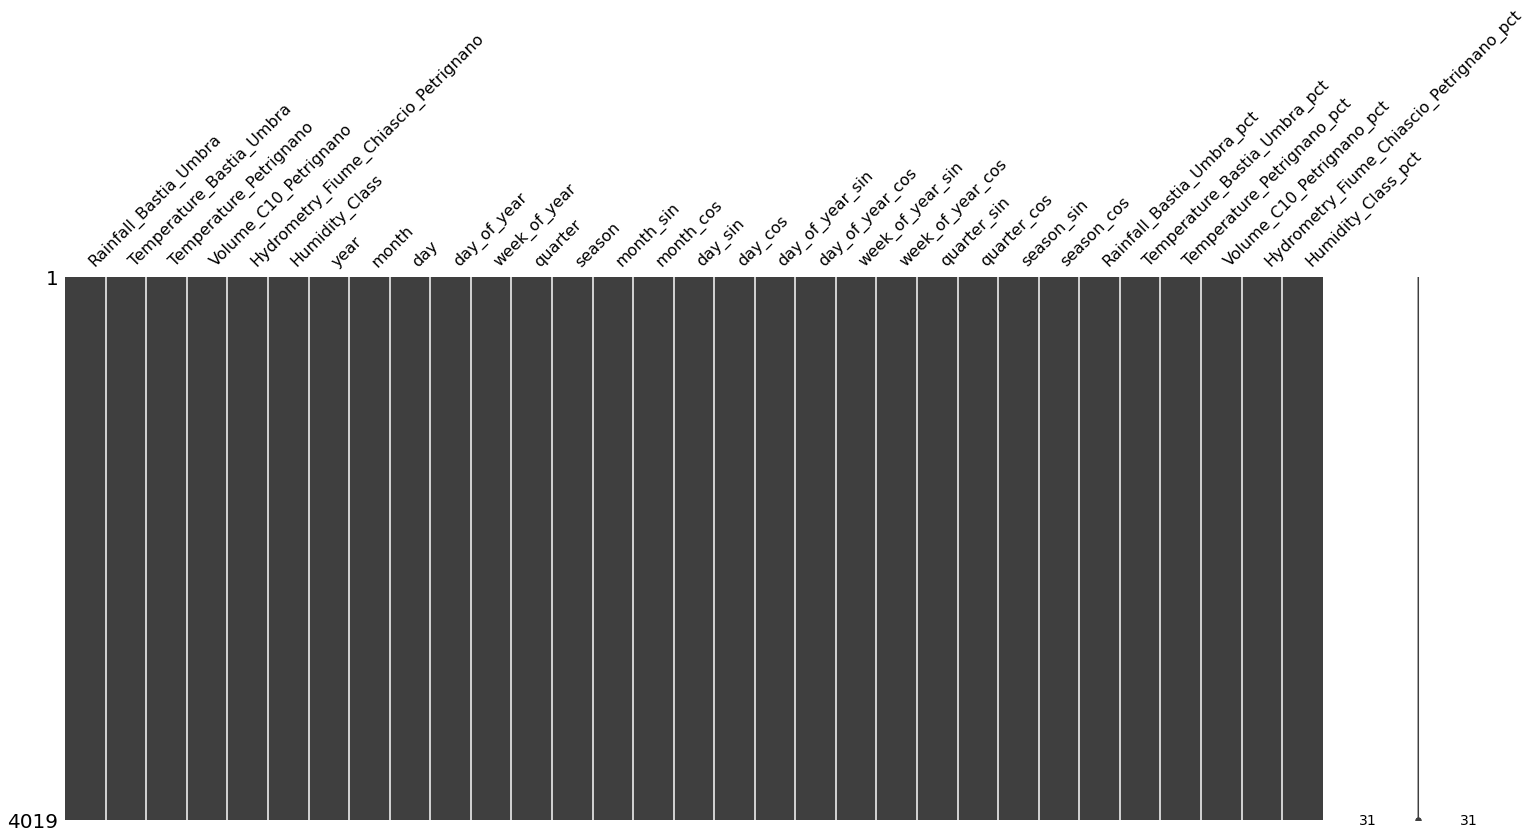

In [18]:
msno.matrix(X)

In [19]:
Y = pd.DataFrame()
Y['Depth'] = df['Depth_to_Groundwater_P25'].shift(-1)
Y=Y.loc[X.index, :]
X.head(100)

Rainfall_Bastia_Umbra  Temperature_Bastia_Umbra  \
Date                                                          
2009-01-01                   0.00                      2.30   
2009-01-02                   0.00                      4.40   
2009-01-03                   0.00                      0.80   
2009-01-04                   0.00                     -1.90   
2009-01-05                   0.00                     -0.70   
...                           ...                       ...   
2009-04-07                   0.00                     14.50   
2009-04-08                   0.20                     14.30   
2009-04-09                   0.00                     14.30   
2009-04-10                   0.00                     14.40   
2009-04-11                   0.00                     14.90   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                                                        
2009-01-01                    2.50              -28785.89   
2009-01-02                    3.90              -25766.21   
2009-01-03                    0.80              -27919.30   
2009-01-04                   -2.10              -29854.66   
2009-01-05                   -0.70              -29124.58   
...                            ...                    ...   
2009-04-07                   13.40              -30295.30   
2009-04-08                   13.90              -30932.93   
2009-04-09                   13.80              -29541.89   
2009-04-10                   13.60              -28015.20   
2009-04-11                   14.20              -24519.46   

            Hydrometry_Fiume_Chiascio_Petrignano  Humidity_Class    year  \
Date                                                                       
2009-01-01                                  2.50           -6.00 2009.00   
2009-01-02                                  2.40           -6.00 2009.00   
2009-01-03                                  2.40           -6.00 2009.00   
2009-01-04                                  2.30           -6.00 2009.00   
2009-01-05                                  2.30           -6.00 2009.00   
...                                          ...             ...     ...   
2009-04-07                                  2.50           -6.00 2009.00   
2009-04-08                                  2.40           -6.00 2009.00   
2009-04-09                                  2.40           -6.00 2009.00   
2009-04-10                                  2.40           -6.00 2009.00   
2009-04-11                                  2.40           -6.00 2009.00   

            month   day  day_of_year  week_of_year  quarter  season  \
Date                                                                  
2009-01-01   1.00  2.00         2.00          1.00     1.00    1.00   
2009-01-02   1.00  3.00         3.00          1.00     1.00    1.00   
2009-01-03   1.00  4.00         4.00          1.00     1.00    1.00   
2009-01-04   1.00  5.00         5.00          2.00     1.00    1.00   
2009-01-05   1.00  6.00         6.00          2.00     1.00    1.00   
...           ...   ...          ...           ...      ...     ...   
2009-04-07   4.00  8.00        98.00         15.00     2.00    2.00   
2009-04-08   4.00  9.00        99.00         15.00     2.00    2.00   
2009-04-09   4.00 10.00       100.00         15.00     2.00    2.00   
2009-04-10   4.00 11.00       101.00         15.00     2.00    2.00   
2009-04-11   4.00 12.00       102.00         15.00     2.00    2.00   

            month_sin  month_cos  day_sin  day_cos  day_of_year_sin  \
Date                                                                  
2009-01-01       0.50       0.87     0.41     0.91             0.03   
2009-01-02       0.50       0.87     0.59     0.81             0.05   
2009-01-03       0.50       0.87     0.74     0.67             0.07   
2009-01-04       0.50       0.87     0.87     0.50             0.09   
2009-01-05       0.50       0.87     0.95     0.31         

In [20]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=Y.index, y=Y.Depth, name="Depth To Groundwater"))
# Edit the layout
fig.update_layout(showlegend=False, title="Depth To Groundwater by Date",
                           xaxis_title="Date")

fig.show()
plot_to_html("bruh1.html",fig)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




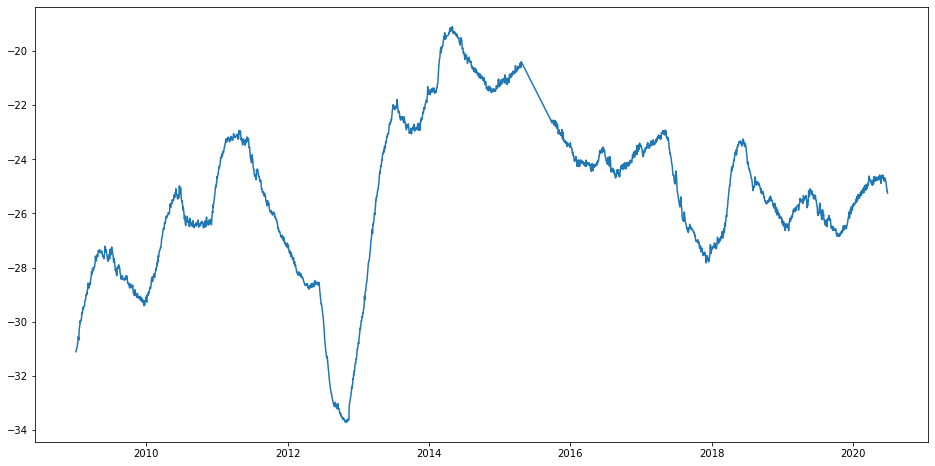

Depth
Date             
2009-01-01 -31.11
2009-01-02 -31.07
2009-01-03 -31.05
2009-01-04 -31.01
2009-01-05 -31.00

In [21]:
fig = plt.figure(figsize=(16,8))
plt.plot(Y['Depth'])
plt.show()
Y.head()

## Check for multicollinearity

In [22]:

# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif.sort_values('VIF', ascending=False)

    return(vif)

In [23]:
X_vif = X.iloc[:,:-1]
calc_vif(X_vif)

variables       VIF
7                                      month 330467.18
9                                day_of_year 292775.38
6                                       year   7194.35
8                                        day   2186.04
1                   Temperature_Bastia_Umbra    963.62
2                     Temperature_Petrignano    951.20
17                           day_of_year_sin    467.17
18                           day_of_year_cos    464.23
19                          week_of_year_sin    427.17
20                          week_of_year_cos    417.77
11                                   quarter    134.35
4       Hydrometry_Fiume_Chiascio_Petrignano    105.86
3                      Volume_C10_Petrignano    105.01
5                             Humidity_Class     94.95
10                              week_of_year     78.17
13                                 month_sin     68.43
14                                 month_cos     67.43
12                                    season     38.72
24                                season_cos     17.55
22                               quarter_cos     11.89
21                               quarter_sin     11.81
23                                season_sin     11.26
15                                   day_sin      2.37
0                      Rainfall_Bastia_Umbra      1.55
25                 Rainfall_Bastia_Umbra_pct      1.22
29  Hydrometry_Fiume_Chiascio_Petrignano_pct      1.17
28                 Volume_C10_Petrignano_pct      1.14
16                                   day_cos      1.04
27                Temperature_Petrignano_pct      1.02
26              Temperature_Bastia_Umbra_pct      1.01

In [24]:
# X = X.drop(['month_sin','month_cos','day_of_year_sin', 'day_of_year_cos', 'week_of_year_sin', 'week_of_year_cos'],axis=1)
calc_vif(X)

variables       VIF
7                                      month 330645.85
9                                day_of_year 292936.08
6                                       year   7201.28
8                                        day   2187.09
1                   Temperature_Bastia_Umbra    963.62
2                     Temperature_Petrignano    951.20
17                           day_of_year_sin    467.25
18                           day_of_year_cos    464.38
19                          week_of_year_sin    427.23
20                          week_of_year_cos    417.87
11                                   quarter    134.35
4       Hydrometry_Fiume_Chiascio_Petrignano    105.94
3                      Volume_C10_Petrignano    105.01
5                             Humidity_Class     95.46
10                              week_of_year     78.17
13                                 month_sin     68.44
14                                 month_cos     67.44
12                                    season     38.74
24                                season_cos     17.55
22                               quarter_cos     11.89
21                               quarter_sin     11.82
23                                season_sin     11.26
15                                   day_sin      2.37
0                      Rainfall_Bastia_Umbra      1.55
25                 Rainfall_Bastia_Umbra_pct      1.22
29  Hydrometry_Fiume_Chiascio_Petrignano_pct      1.17
28                 Volume_C10_Petrignano_pct      1.14
16                                   day_cos      1.04
27                Temperature_Petrignano_pct      1.02
30                        Humidity_Class_pct      1.02
26              Temperature_Bastia_Umbra_pct      1.01

In [25]:
k = np.where(Y.values >= np.finfo('float64').max)
print(k)

(array([], dtype=int64), array([], dtype=int64))


In [26]:
def train_valid_test_split(df, trainFraction, validFraction):
    assert(trainFraction + validFraction < 1)
    X = df.copy()
    
    trainset=np.arange(np.round(trainFraction*X.shape[0]))
    validset=np.arange(trainset[-1]+1,trainset[-1]+1+np.round(validFraction*X.shape[0]))
    testset=np.arange(validset[-1]+1,X.shape[0])
    
    X_train, X_valid, X_test = X.iloc[trainset,], X.iloc[validset,], X.iloc[testset,] 
    
    return X_train, X_valid, X_test

trainFrac=0.6
validFrac=0.2

X_train, X_valid, X_test=train_valid_test_split(X, trainFrac, validFrac)
X_train.tail()

Rainfall_Bastia_Umbra  Temperature_Bastia_Umbra  \
Date                                                          
2016-01-20                   0.20                      4.40   
2016-01-21                   0.20                      2.10   
2016-01-22                   0.20                      0.40   
2016-01-23                   0.20                      0.30   
2016-01-24                   0.00                      1.10   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                                                        
2016-01-20                    5.00              -28629.50   
2016-01-21                    3.20              -28415.23   
2016-01-22                    0.80              -28496.45   
2016-01-23                    1.00              -28143.94   
2016-01-24                    1.30              -28432.51   

            Hydrometry_Fiume_Chiascio_Petrignano  Humidity_Class    year  \
Date                                                                       
2016-01-20                                  2.90           -5.00 2016.00   
2016-01-21                                  2.80           -5.00 2016.00   
2016-01-22                                  2.80           -5.00 2016.00   
2016-01-23                                  2.80           -5.00 2016.00   
2016-01-24                                  2.80           -5.00 2016.00   

            month   day  day_of_year  week_of_year  quarter  season  \
Date                                                                  
2016-01-20   1.00 21.00        21.00          3.00     1.00    1.00   
2016-01-21   1.00 22.00        22.00          3.00     1.00    1.00   
2016-01-22   1.00 23.00        23.00          3.00     1.00    1.00   
2016-01-23   1.00 24.00        24.00          3.00     1.00    1.00   
2016-01-24   1.00 25.00        25.00          4.00     1.00    1.00   

            month_sin  month_cos  day_sin  day_cos  day_of_year_sin  \
Date                                                                  
2016-01-20       0.50       0.87    -0.95    -0.31             0.35   
2016-01-21       0.50       0.87    -0.99    -0.10             0.37   
2016-01-22       0.50       0.87    -0.99     0.10             0.39   
2016-01-23       0.50       0.87    -0.95     0.31             0.40   
2016-01-24       0.50       0.87    -0.87     0.50             0.42   

            day_of_year_cos  week_of_year_sin  week_of_year_cos  quarter_sin  \
Date                                                                           
2016-01-20             0.94              0.35              0.94         1.00   
2016-01-21             0.93              0.35              0.94         1.00   
2016-01-22             0.92              0.35              0.94         1.00   
2016-01-23             0.92              0.35              0.94         1.00   
2016-01-24             0.91              0.46              0.89         1.00   

            quarter_cos  season_sin  season_cos  Rainfall_Bastia_Umbra_pct  \
Date                                                                         
2016-01-20         0.00        1.00        0.00                       0.00   
2016-01-21         0.00        1.00        0.00                       0.00   
2016-01-22         0.00        1.00        0.00                       0.00   
2016-01-23         0.00        1.00        0.00                       0.00   
2016-01-24         0.00        1.00        0.00                      -1.00   

            Temperature_Bastia_Umbra_pct  Temperature_Petrignano_pct  \
Date                                                                   
2016-01-20                        -23.00                       24.00   
2016-01-21                         -0.52                       -0.36   
2016-01-22                         -0.81                       -0.75   
2016-01-23                         -0.25                        0.25   
2016-01-24                          2.67                        0.30   



In [27]:
X_rf = X.copy()

X_rf['previous_1_day'] = Y.shift(1)
X_rf['previous_2_day'] = Y.shift(2)
X_rf['previous_3_day'] = Y.shift(3)
X_rf['previous_4_day'] = Y.shift(4)
X_rf['previous_5_day'] = Y.shift(5)
X_rf['previous_6_day'] = Y.shift(6)
X_rf['previous_7_day'] = Y.shift(7)
X_rf = X_rf.dropna()
Y_rf = Y.loc[X_rf.index]
Y_rf = Y_rf.fillna(Y_rf.mean())

trainFrac=0.6
validFrac=0.2

X_rf_train, X_rf_valid, X_rf_test=train_valid_test_split(X_rf, trainFrac, validFrac)
y_rf_train, y_rf_valid, y_rf_test=train_valid_test_split(Y_rf, trainFrac, validFrac)
X_rf_train.head()

Rainfall_Bastia_Umbra  Temperature_Bastia_Umbra  \
Date                                                          
2009-01-08                   0.90                      4.90   
2009-01-09                   0.00                      1.90   
2009-01-10                   0.00                      3.40   
2009-01-11                   0.00                      3.30   
2009-01-12                   1.10                      6.00   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                                                        
2009-01-08                    4.80              -30597.70   
2009-01-09                    4.20              -31337.28   
2009-01-10                    4.50              -29845.15   
2009-01-11                    3.90              -28745.28   
2009-01-12                    6.30              -28932.77   

            Hydrometry_Fiume_Chiascio_Petrignano  Humidity_Class    year  \
Date                                                                       
2009-01-08                                  2.30           -6.00 2009.00   
2009-01-09                                  2.30           -6.00 2009.00   
2009-01-10                                  2.30           -6.00 2009.00   
2009-01-11                                  2.30           -6.00 2009.00   
2009-01-12                                  2.30           -6.00 2009.00   

            month   day  day_of_year  week_of_year  quarter  season  \
Date                                                                  
2009-01-08   1.00  9.00         9.00          2.00     1.00    1.00   
2009-01-09   1.00 10.00        10.00          2.00     1.00    1.00   
2009-01-10   1.00 11.00        11.00          2.00     1.00    1.00   
2009-01-11   1.00 12.00        12.00          3.00     1.00    1.00   
2009-01-12   1.00 13.00        13.00          3.00     1.00    1.00   

            month_sin  month_cos  day_sin  day_cos  day_of_year_sin  \
Date                                                                  
2009-01-08       0.50       0.87     0.95    -0.31             0.15   
2009-01-09       0.50       0.87     0.87    -0.50             0.17   
2009-01-10       0.50       0.87     0.74    -0.67             0.19   
2009-01-11       0.50       0.87     0.59    -0.81             0.21   
2009-01-12       0.50       0.87     0.41    -0.91             0.22   

            day_of_year_cos  week_of_year_sin  week_of_year_cos  quarter_sin  \
Date                                                                           
2009-01-08             0.99              0.24              0.97         1.00   
2009-01-09             0.99              0.24              0.97         1.00   
2009-01-10             0.98              0.24              0.97         1.00   
2009-01-11             0.98              0.35              0.94         1.00   
2009-01-12             0.98              0.35              0.94         1.00   

            quarter_cos  season_sin  season_cos  Rainfall_Bastia_Umbra_pct  \
Date                                                                         
2009-01-08         0.00        1.00        0.00                       0.00   
2009-01-09         0.00        1.00        0.00                      -1.00   
2009-01-10         0.00        1.00        0.00                       0.00   
2009-01-11         0.00        1.00        0.00                       0.00   
2009-01-12         0.00        1.00        0.00                       0.00   

            Temperature_Bastia_Umbra_pct  Temperature_Petrignano_pct  \
Date                                                                   
2009-01-08                          0.14                       -0.27   
2009-01-09                         -0.61                       -0.12   
2009-01-10                          0.79                        0.07   
2009-01-11                         -0.03                       -0.13   
2009-01-12                          0.82                        0.62   



In [28]:
y_train, y_valid, y_test=train_valid_test_split(Y, trainFrac, validFrac)
y_train.tail()

Depth
Date             
2016-01-20 -23.90
2016-01-21 -24.01
2016-01-22 -24.05
2016-01-23 -24.08
2016-01-24 -24.07

In [29]:
X_test.drop(X_test.tail(1).index,inplace=True)
y_test.drop(y_test.tail(1).index,inplace=True)

In [30]:
X.drop(X.tail(1).index,inplace=True)
Y.drop(Y.tail(1).index,inplace=True)

# Machine Learning Models

## Regression Models

In [31]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from pyearth import Earth

def get_all_sklearn_regressors():
    from sklearn.utils import all_estimators

    estimators = all_estimators(type_filter='regressor')
    # pre-ran with error catching
    working_list  = ['ARDRegression',
                     'AdaBoostRegressor',
                     'BaggingRegressor',
                     'BayesianRidge',
                     'CCA',
                     'DecisionTreeRegressor',
                     'DummyRegressor',
                     'ElasticNet',
                     'ElasticNetCV',
                     'ExtraTreeRegressor',
                     'ExtraTreesRegressor',
                     'GaussianProcessRegressor',
                     'GradientBoostingRegressor',
                     'HistGradientBoostingRegressor',
                     'KNeighborsRegressor',
                     'LarsCV',
                     'Lasso',
                     'LassoCV',
                     'LassoLars',
                     'LassoLarsCV',
                     'LassoLarsIC',
                     'LinearRegression',
                     'LinearSVR',
                     'MLPRegressor',
                     'NuSVR',
                     'OrthogonalMatchingPursuit',
                     'PLSCanonical',
                     'PLSRegression',
                     'PassiveAggressiveRegressor',
                     'RANSACRegressor',
                     'RandomForestRegressor',
                     'Ridge',
                     'RidgeCV',
                     'SVR',
                     'TheilSenRegressor',
                     'TransformedTargetRegressor',
                     'TweedieRegressor']
    all_regs = []
    for name, RegressorClass in estimators:
        if name not in working_list:
            continue
        try:
            reg = RegressorClass()
            all_regs.append(reg)
        except Exception as e:
#             print(e)
            pass
    return all_regs

model_list = get_all_sklearn_regressors()
model_list.extend([xgb.XGBRegressor()])
model_list.extend([Earth()]) # MARS but its called Earth on python?

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import time

results_list = []
working_list=[]
for model in tqdm(model_list):
    try:
        start = time.time()
        model.fit(X_rf_train, y_rf_train)

        y_predicted = model.predict(X_rf_valid)
        
        y_predicted_test = model.predict(X_rf_test)

        # Accuracy
        # RMSE & MAE
    #     print(f"{model.__class__.__name__}'s MAE : ",mean_absolute_error(y_test, y_predicted))
    #     print(f"{model.__class__.__name__}'s RMSE: ",mean_squared_error(y_test, y_predicted, squared=False))
        end = time.time()
        time_taken = end-start
        results_list.append([model.__class__.__name__,
                             mean_absolute_error(y_rf_valid, y_predicted),
                             mean_squared_error(y_rf_valid, y_predicted, squared=False),
                             mean_absolute_error(y_rf_test, y_predicted_test),
                             mean_squared_error(y_rf_test, y_predicted_test, squared=False),
                             time_taken])
        working_list.append(model.__class__.__name__)
    except Exception as e:
        print(e,"---------",model.__class__.__name__)

  0%|          | 0/39 [00:00<?, ?it/s]

### Models Evaluation

In [33]:
res = pd.DataFrame(results_list,columns=['Regressor','Valid MAE','Valid RMSE','Test MAE','Test RMSE',"Time Taken"]).sort_values(by=["Test MAE"])

In [34]:
res.loc[res['Test MAE'] >= (res.loc[res['Regressor'] == 'RandomForestRegressor']['Test MAE'].item())]

Regressor  Valid MAE  Valid RMSE  Test MAE  Test RMSE  \
30          RandomForestRegressor       0.06        0.08      0.06       0.08   
2                BaggingRegressor       0.07        0.09      0.07       0.09   
10            ExtraTreesRegressor       0.07        0.09      0.07       0.09   
13  HistGradientBoostingRegressor       0.07        0.08      0.07       0.09   
37                   XGBRegressor       0.09        0.12      0.08       0.10   
5           DecisionTreeRegressor       0.10        0.13      0.10       0.13   
9              ExtraTreeRegressor       0.11        0.14      0.11       0.14   
4                             CCA       0.24        0.26      0.13       0.16   
7                      ElasticNet       0.16        0.18      0.16       0.20   
36               TweedieRegressor       0.16        0.18      0.20       0.88   
16                          Lasso       0.19        0.22      0.21       0.26   
1               AdaBoostRegressor       0.14        0.18      0.21       0.27   
6                  DummyRegressor       1.45        1.54      0.69       0.86   
18                      LassoLars       1.45        1.54      0.69       0.86   
23                   MLPRegressor       0.80        1.10      0.88       1.53   
17                        LassoCV       1.07        1.31      1.25       1.50   
8                    ElasticNetCV       1.11        1.36      1.29       1.56   
27                  PLSRegression       0.84        0.88      1.42       8.39   
22                      LinearSVR       1.29        1.57      1.48       1.91   
24                          NuSVR       1.60        1.95      1.85       2.17   
14            KNeighborsRegressor       1.77        2.17      1.97       2.41   
33                            SVR       1.97        2.31      2.13       2.52   
28     PassiveAggressiveRegressor       2.59        2.91      2.75       3.21   
26                   PLSCanonical       4.31        4.90      4.60      26.57   
11       GaussianProcessRegressor      24.88       24.92     25.42      25.43   

    Time Taken  
30        3.39  
2         0.35  
10        1.71  
13        1.01  
37        0.57  
5         0.09  
9         0.07  
4         0.06  
7         0.05  
36        0.06  
16        0.17  
1         0.73  
6         0.01  
18        0.02  
23        2.94  
17        0.36  
8         0.16  
27        0.02  
22        0.46  
24        0.66  
14        0.05  
33        0.93  
28        0.03  
26        0.01  
11        0.93

In [35]:
res.loc[res['Regressor'] == 'Earth']

Regressor  Valid MAE  Valid RMSE  Test MAE  Test RMSE  Time Taken
38     Earth       0.05        0.07      0.05       0.07        0.05

In [36]:
res

Regressor  Valid MAE  Valid RMSE  Test MAE  Test RMSE  \
0                   ARDRegression       0.04        0.05      0.04       0.05   
25      OrthogonalMatchingPursuit       0.04        0.06      0.04       0.06   
32                        RidgeCV       0.04        0.05      0.04       0.06   
3                   BayesianRidge       0.04        0.05      0.04       0.06   
29                RANSACRegressor       0.04        0.06      0.04       0.06   
35     TransformedTargetRegressor       0.04        0.06      0.04       0.07   
21               LinearRegression       0.04        0.06      0.04       0.07   
31                          Ridge       0.04        0.06      0.05       0.06   
19                    LassoLarsCV       0.04        0.06      0.05       0.06   
15                         LarsCV       0.04        0.06      0.05       0.06   
34              TheilSenRegressor       0.05        0.09      0.05       0.11   
38                          Earth       0.05        0.07      0.05       0.07   
20                    LassoLarsIC       0.05        0.07      0.05       0.07   
12      GradientBoostingRegressor       0.06        0.08      0.06       0.07   
30          RandomForestRegressor       0.06        0.08      0.06       0.08   
2                BaggingRegressor       0.07        0.09      0.07       0.09   
10            ExtraTreesRegressor       0.07        0.09      0.07       0.09   
13  HistGradientBoostingRegressor       0.07        0.08      0.07       0.09   
37                   XGBRegressor       0.09        0.12      0.08       0.10   
5           DecisionTreeRegressor       0.10        0.13      0.10       0.13   
9              ExtraTreeRegressor       0.11        0.14      0.11       0.14   
4                             CCA       0.24        0.26      0.13       0.16   
7                      ElasticNet       0.16        0.18      0.16       0.20   
36               TweedieRegressor       0.16        0.18      0.20       0.88   
16                          Lasso       0.19        0.22      0.21       0.26   
1               AdaBoostRegressor       0.14        0.18      0.21       0.27   
6                  DummyRegressor       1.45        1.54      0.69       0.86   
18                      LassoLars       1.45        1.54      0.69       0.86   
23                   MLPRegressor       0.80        1.10      0.88       1.53   
17                        LassoCV       1.07        1.31      1.25       1.50   
8                    ElasticNetCV       1.11        1.36      1.29       1.56   
27                  PLSRegression       0.84        0.88      1.42       8.39   
22                      LinearSVR       1.29        1.57      1.48       1.91   
24                          NuSVR       1.60        1.95      1.85       2.17   
14            KNeighborsRegressor       1.77        2.17      1.97       2.41   
33                            SVR       1.97        2.31      2.13       2.52   
28     PassiveAggressiveRegressor       2.59        2.91      2.75       3.21   
26                   PLSCanonical       4.31        4.90      4.60      26.57   
11       GaussianProcessRegressor      24.88       24.92     25.42      25.43   

    Time Taken  
0         0.09  
25        0.01  
32        0.04  
3         0.06  
29        0.04  
35        0.02  
21        0.04  
31        0.02  
19        0.18  
15        0.25  
34        5.47  
38        0.05  
20        0.06  
12        1.43  
30        3.39  
2         0.35  
10        1.71  
13        1.01  
37        0.57  
5         0.09  
9         0.07  
4         0.06  
7         0.05  
36        0.06  
16        0.17  
1         0.73  
6         0.01  
18        0.02  
23        2.94  
17        0.36  
8         0.16  
27        0.02  
22        0.46  
24        0.66  
14        0.05  
33        0.93  
28        0.03  
26        0.01  
11        0.93

## Linear Regression
fit linear regression on all data

In [37]:
import statsmodels.api as sm
mod = sm.OLS(Y_rf,X_rf)

linreg = mod.fit()

print(linreg.summary())

                                 OLS Regression Results                                
Dep. Variable:                  Depth   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          1.864e+07
Date:                Sat, 03 Apr 2021   Prob (F-statistic):                        0.00
Time:                        19:02:42   Log-Likelihood:                          5571.4
No. Observations:                4012   AIC:                                 -1.107e+04
Df Residuals:                    3974   BIC:                                 -1.083e+04
Df Model:                          38                                                  
Covariance Type:            nonrobust                                                  
                                               coef    std err          t      P>|t|      [0.025      0.975]
-----------

## MARS Model
fit mars on all data

In [38]:
MARS_model = Earth()
MARS_model.fit(X_rf, Y_rf)

Earth()

In [39]:
print(MARS_model.summary())

Earth Model
-------------------------------------
Basis Function  Pruned  Coefficient  
-------------------------------------
(Intercept)     No      -0.0187229   
previous_1_day  No      0.999205     
-------------------------------------
MSE: 0.0053, GCV: 0.0053, RSQ: 0.9994, GRSQ: 0.9994


## Random Forest Regressor

fit random forest on all data

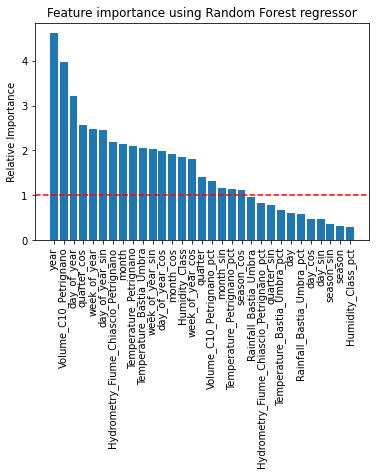

In [40]:
from sklearn.ensemble import RandomForestRegressor
# random forest Regressor model using all data
# overwrite default python 
# Python used default B = 100. Please override to 500.
# Python used default RSF size = numof X variables. Please override to int(numof X variables/3).
regressor = RandomForestRegressor(n_estimators=100,max_features=int(len(X_valid.columns)/3))
regressor.fit(X_valid, y_valid)

# Extract feature importances
feature_importances = regressor.feature_importances_
feature_names = X_valid.columns

# Normalize the importance values
feature_importances = np.log(100.0 * (feature_importances / max(feature_importances))+1)

# Sort the values and flip them
index_sorted = np.flipud(np.argsort(feature_importances))

# Arrange the X ticks
pos = np.arange(index_sorted.shape[0]) + 0.5

# fig = go.Figure()
# # Create and style traces
# fig.add_trace([go.Bar(x=feature_names[index_sorted], y=feature_importances[index_sorted])])
# # Edit the layout
# fig.update_layout(showlegend=False, title="Feature importance using Random Forest Regressor",
#                            xaxis_title="Features", yaxis_title="Relative Importance")

# fig.show()
# plot_to_html("bruh2.html",fig)

# Plot the bar graph
plt.figure()
plt.bar(pos, feature_importances[index_sorted], align='center')
plt.axhline(y=1, linestyle='dashed', color='red')
plt.xticks(pos, feature_names[index_sorted], rotation = 90)
plt.ylabel('Relative Importance')
plt.title('Feature importance using Random Forest regressor')
plt.show()

In [41]:
# only select relative features > 1%
feature_list = ['year', 'Volume_C10_Petrignano', 'day_of_year', 'week_of_year', 'month',
       'day_of_year_sin', 'quarter_cos',
       'Hydrometry_Fiume_Chiascio_Petrignano', 'Temperature_Bastia_Umbra',
       'Temperature_Petrignano', 'day_of_year_cos', 'week_of_year_sin',
       'week_of_year_cos', 'Humidity_Class', 'month_cos',
       'Volume_C10_Petrignano_pct', 'quarter','previous_1_day','previous_2_day','previous_3_day','previous_4_day','previous_5_day','previous_6_day','previous_7_day']

In [42]:
feature_names[index_sorted]

Index(['year', 'Volume_C10_Petrignano', 'day_of_year', 'quarter_cos',
       'week_of_year', 'day_of_year_sin',
       'Hydrometry_Fiume_Chiascio_Petrignano', 'month',
       'Temperature_Petrignano', 'Temperature_Bastia_Umbra',
       'week_of_year_sin', 'day_of_year_cos', 'month_cos', 'Humidity_Class',
       'week_of_year_cos', 'quarter', 'Volume_C10_Petrignano_pct', 'month_sin',
       'Temperature_Petrignano_pct', 'season_cos', 'Rainfall_Bastia_Umbra',
       'Hydrometry_Fiume_Chiascio_Petrignano_pct', 'quarter_sin',
       'Temperature_Bastia_Umbra_pct', 'day', 'Rainfall_Bastia_Umbra_pct',
       'day_cos', 'day_sin', 'season_sin', 'season', 'Humidity_Class_pct'],
      dtype='object')

In [43]:
import shap
explainer = shap.Explainer(regressor)
shap_values = explainer(X_valid)


In [44]:
shap.initjs()
shap.plots.force(shap_values[0])


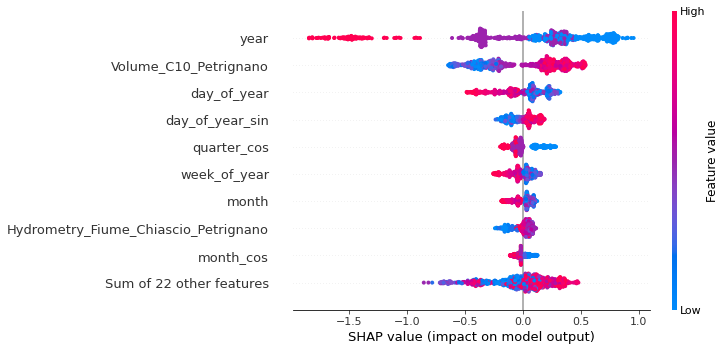

In [45]:
shap.plots.beeswarm(shap_values)


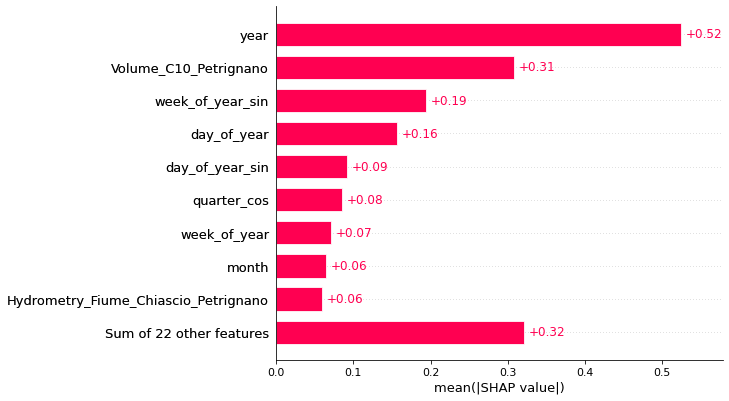

In [46]:
shap.plots.bar(shap_values)


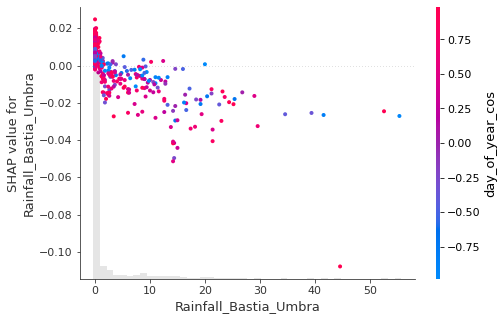

In [47]:
shap.plots.scatter(shap_values[:,0], color=shap_values)


In [48]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=feature_names[index_sorted], y=feature_importances[index_sorted]))
# Edit the layout
fig.update_layout(showlegend=False, title="Feature Importance using Random Forest Regressor",
                           xaxis_title="Features", yaxis_title="Relative Importance", height=700)

fig.show()
plot_to_html("bruh2.html",fig)

Text(0.5, 0, 'Tree depth')

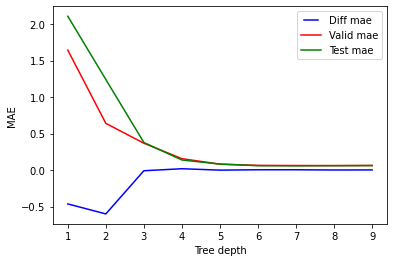

In [49]:
max_depths = range(1,10)

train_results = []
valid_results = []
test_results = []
diff_results = []

for i in max_depths:
    rf = RandomForestRegressor(max_depth=i)
    rf.fit(X_rf_train, y_rf_train)    
    #compute accuracy for train data
    pred_res = rf.predict(X_rf_train)
    mae = mean_absolute_error(y_rf_train, pred_res)
    # errors = abs(pred_res - y_train)
    # Calculate mean absolute percentage error (MAPE)
    # mape = 100 * (errors / y_train)
    # Calculate and display accuracy
    # accuracy = 100 - np.mean(mape)
    #append results of accuracy
    train_results.append(mae)
    
    #now again for valid data
    pred_res = rf.predict(X_rf_valid)
    val_mae = mean_absolute_error(y_rf_valid, pred_res)
    #errors = abs(pred_res - y_valid)
    # Calculate mean absolute percentage error (MAPE)
    #mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    #accuracy = 100 - np.mean(mape)
    #append results of accuracy
    valid_results.append(val_mae)
    
    #now again for test data
    pred_res = rf.predict(X_rf_test)
    test_mae = mean_absolute_error(y_rf_test, pred_res)
    #errors = abs(pred_res - y_valid)
    # Calculate mean absolute percentage error (MAPE)
    #mape = 100 * (errors / y_test)
    # Calculate and display accuracy
    #accuracy = 100 - np.mean(mape)
    #append results of accuracy
    test_results.append(test_mae)
    diff_results.append(val_mae-test_mae)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, diff_results, 'b', label='Diff mae')
line2, = plt.plot(max_depths, valid_results, 'r', label= 'Valid mae')
line3, = plt.plot(max_depths, test_results, 'g', label= 'Test mae')

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('MAE')
plt.xlabel('Tree depth')

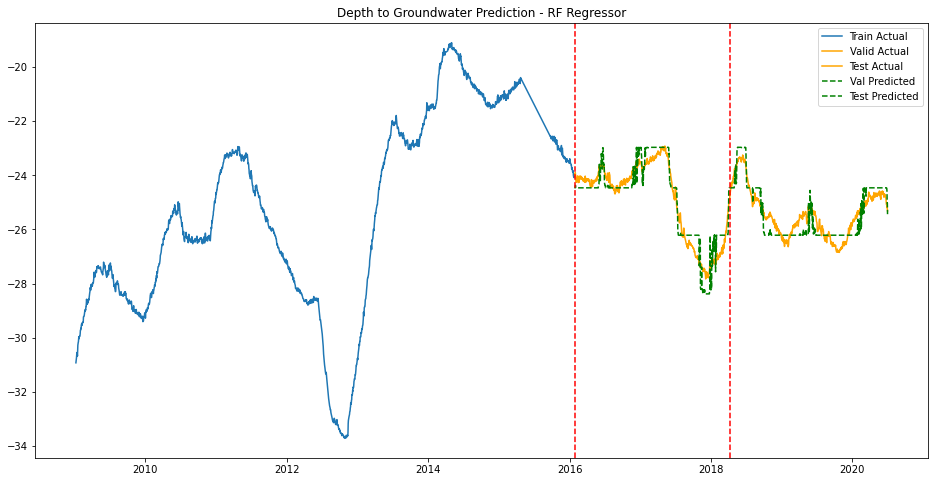

RMSE on val-set: 0.44606637312791464
RMSE on test-set: 0.4288132594277734


In [50]:
rf = RandomForestRegressor(max_depth=3)
rf.fit(X_rf_train[feature_list], y_rf_train)   

y_hat_val = y_rf_valid.copy()
y_hat_test = y_rf_test.copy()

y_hat_val['Val_pred'] = rf.predict(X_rf_valid[feature_list])
y_hat_test['Test_pred'] = rf.predict(X_rf_test[feature_list])

plt.figure(figsize=(16,8))
plt.plot(y_rf_train['Depth'], label='Train Actual')
plt.plot(y_rf_valid['Depth'], label='Valid Actual',color='orange')
plt.plot(y_rf_test['Depth'], label='Test Actual',color='orange')
plt.plot(y_hat_val['Val_pred'], label='Val Predicted', linestyle='dashed',color='green')
plt.plot(y_hat_test['Test_pred'], label='Test Predicted', linestyle='dashed',color='green')
plt.axvline(x=y_hat_val.index[0], linestyle='dashed',color='red')
plt.axvline(x=y_hat_test.index[0], linestyle='dashed',color='red')
plt.title("Depth to Groundwater Prediction - RF Regressor")
plt.legend(loc='best')
plt.show()
rmse_val = np.sqrt(mean_squared_error(y_rf_valid, y_hat_val['Val_pred']))
rmse_test = np.sqrt(mean_squared_error(y_rf_test, y_hat_test['Test_pred']))
print('RMSE on val-set:', rmse_val)
print('RMSE on test-set:', rmse_test)

In [51]:
val_pred = y_hat_val['Val_pred']
test_pred = y_hat_test['Test_pred']

rf_val_pred = pd.DataFrame(val_pred, index=y_rf_valid.index)
rf_val_pred.columns=["Val_Predicted"]

rf_test_pred = pd.DataFrame(test_pred, index=y_rf_test.index)
rf_test_pred.columns=["Test_Predicted"]




fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=y_rf_train.index, y=y_rf_train["Depth"], name="Train Actual"))
fig.add_trace(go.Scatter(x=y_rf_valid.index, y=y_rf_valid["Depth"], name="Valid Actual",line=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=y_rf_test.index, y=y_rf_test["Depth"], name="Test Actual",line=dict(color='RoyalBlue')))

fig.add_trace(go.Scatter(x=rf_val_pred.index, y=rf_val_pred.Val_Predicted, name="Valid Predicted",line=dict(color='LightSeaGreen')))
fig.add_trace(go.Scatter(x=rf_test_pred.index, y=rf_test_pred.Test_Predicted, name="Test Predicted",line=dict(color='LightSeaGreen')))

# # Add shapes
fig.add_shape(type="line",
    x0=y_rf_valid.index[0],x1=y_rf_valid.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
fig.add_shape(type="line",
    x0=y_rf_test.index[0],x1=y_rf_test.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
# Edit the layout
fig.update_layout(showlegend=True, title="Depth To Groundwater Random Forest Predictions",
                           xaxis_title="Date")

fig.show()
plot_to_html("rf.html",fig)


plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



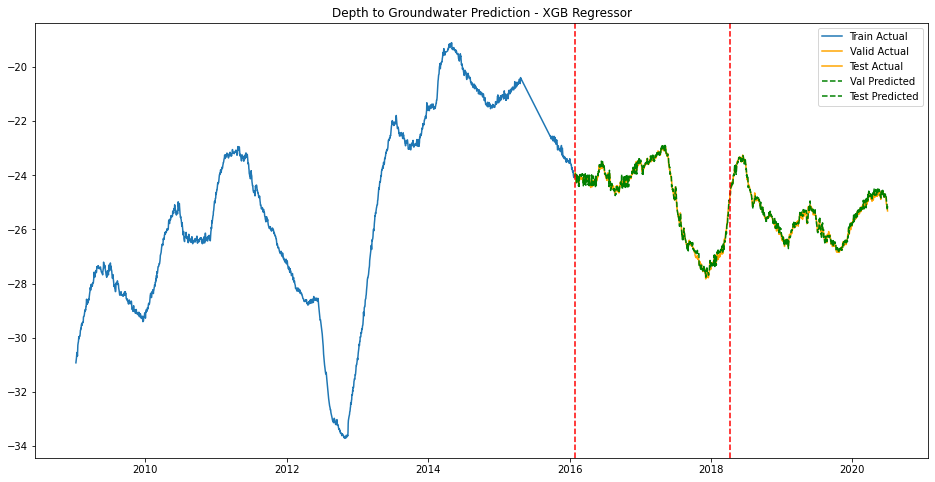

RMSE on val-set: 0.105988953567218
RMSE on test-set: 0.08940871468765178


In [52]:
xgboost = xgb.XGBRegressor()
xgboost.fit(X_rf_train[feature_list], y_rf_train)   

y_xgb_hat_val = y_rf_valid.copy()
y_xgb_hat_test = y_rf_test.copy()

y_xgb_hat_val['Val_pred'] = xgboost.predict(X_rf_valid[feature_list])
y_xgb_hat_test['Test_pred'] = xgboost.predict(X_rf_test[feature_list])

plt.figure(figsize=(16,8))
plt.plot(y_rf_train['Depth'], label='Train Actual')
plt.plot(y_rf_valid['Depth'], label='Valid Actual',color='orange')
plt.plot(y_rf_test['Depth'], label='Test Actual',color='orange')
plt.plot(y_xgb_hat_val['Val_pred'], label='Val Predicted', linestyle='dashed',color='green')
plt.plot(y_xgb_hat_test['Test_pred'], label='Test Predicted', linestyle='dashed',color='green')
plt.axvline(x=y_hat_val.index[0], linestyle='dashed',color='red')
plt.axvline(x=y_hat_test.index[0], linestyle='dashed',color='red')
plt.title("Depth to Groundwater Prediction - XGB Regressor")
plt.legend(loc='best')
plt.show()
rmse_val = np.sqrt(mean_squared_error(y_rf_valid, y_xgb_hat_val['Val_pred']))
rmse_test = np.sqrt(mean_squared_error(y_rf_test, y_xgb_hat_test['Test_pred']))
print('RMSE on val-set:', rmse_val)
print('RMSE on test-set:', rmse_test)

In [53]:
val_pred = y_xgb_hat_val['Val_pred'] 
test_pred = y_xgb_hat_test['Test_pred']

rf_val_pred = pd.DataFrame(val_pred, index=y_rf_valid.index)
rf_val_pred.columns=["Val_Predicted"]

rf_test_pred = pd.DataFrame(test_pred, index=y_rf_test.index)
rf_test_pred.columns=["Test_Predicted"]




fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=y_rf_train.index, y=y_rf_train["Depth"], name="Train Actual"))
fig.add_trace(go.Scatter(x=y_rf_valid.index, y=y_rf_valid["Depth"], name="Valid Actual",line=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=y_rf_test.index, y=y_rf_test["Depth"], name="Test Actual",line=dict(color='RoyalBlue')))

fig.add_trace(go.Scatter(x=rf_val_pred.index, y=rf_val_pred.Val_Predicted, name="Valid Predicted",line=dict(color='LightSeaGreen')))
fig.add_trace(go.Scatter(x=rf_test_pred.index, y=rf_test_pred.Test_Predicted, name="Test Predicted",line=dict(color='LightSeaGreen')))

# # Add shapes
fig.add_shape(type="line",
    x0=y_rf_valid.index[0],x1=y_rf_valid.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
fig.add_shape(type="line",
    x0=y_rf_test.index[0],x1=y_rf_test.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
# Edit the layout
fig.update_layout(showlegend=True, title="Depth To Groundwater XGBoost Predictions",
                           xaxis_title="Date")

fig.show()
plot_to_html("xgb.html",fig)


plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



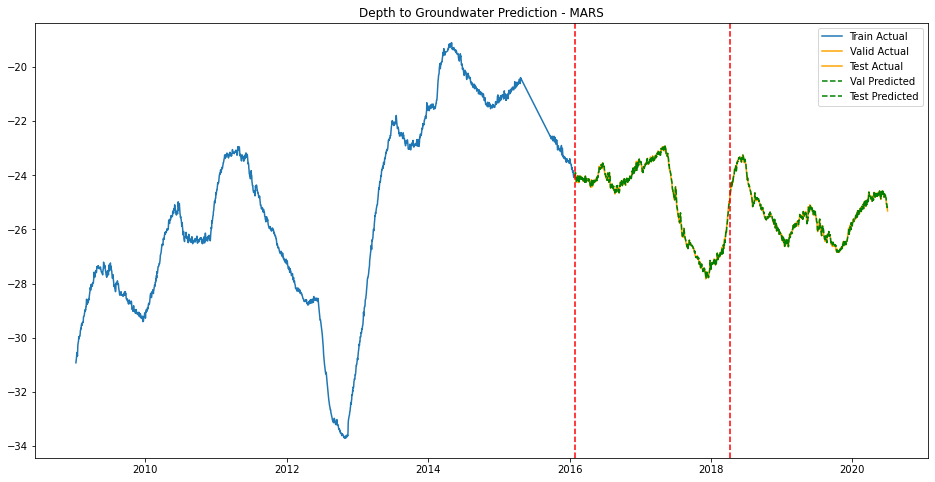

In [54]:
MARS_model = Earth()
MARS_model.fit(X_rf[feature_list], Y_rf) 

y_hat_val = y_rf_valid.copy()
y_hat_test = y_rf_test.copy()

y_hat_val['Val_pred'] = MARS_model.predict(X_rf_valid[feature_list])
y_hat_test['Test_pred'] = MARS_model.predict(X_rf_test[feature_list])

plt.figure(figsize=(16,8))
plt.plot(y_rf_train['Depth'], label='Train Actual')
plt.plot(y_rf_valid['Depth'], label='Valid Actual',color='orange')
plt.plot(y_rf_test['Depth'], label='Test Actual',color='orange')
plt.plot(y_hat_val['Val_pred'], label='Val Predicted', linestyle='dashed',color='green')
plt.plot(y_hat_test['Test_pred'], label='Test Predicted', linestyle='dashed',color='green')
plt.axvline(x=y_hat_val.index[0], linestyle='dashed',color='red')
plt.axvline(x=y_hat_test.index[0], linestyle='dashed',color='red')
plt.title("Depth to Groundwater Prediction - MARS")
plt.legend(loc='best')
plt.show()

In [55]:
val_pred = y_hat_val['Val_pred']
test_pred = y_hat_test['Test_pred']

rf_val_pred = pd.DataFrame(val_pred, index=y_valid.index)
rf_val_pred.columns=["Val_Predicted"]

rf_test_pred = pd.DataFrame(test_pred, index=y_test.index)
rf_test_pred.columns=["Test_Predicted"]
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=y_rf_train.index, y=y_rf_train["Depth"], name="Train Actual"))
fig.add_trace(go.Scatter(x=y_rf_valid.index, y=y_rf_valid["Depth"], name="Valid Actual",line=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=y_rf_test.index, y=y_rf_test["Depth"], name="Test Actual",line=dict(color='RoyalBlue')))

fig.add_trace(go.Scatter(x=rf_val_pred.index, y=rf_val_pred.Val_Predicted, name="Valid Predicted",line=dict(color='LightSeaGreen')))
fig.add_trace(go.Scatter(x=rf_test_pred.index, y=rf_test_pred.Test_Predicted, name="Test Predicted",line=dict(color='LightSeaGreen')))

# # Add shapes
fig.add_shape(type="line",
    x0=y_rf_valid.index[0],x1=y_rf_valid.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
fig.add_shape(type="line",
    x0=y_rf_test.index[0],x1=y_rf_test.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
# Edit the layout
fig.update_layout(showlegend=True, title="Depth To Groundwater MARS Predictions",
                           xaxis_title="Date")

fig.show()
plot_to_html("mars.html",fig)


plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



# Time Series Forecasting 

Decomposing the Time Series

In [56]:
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
 
# holt and holtwinter
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Non-constant fluctuations, mutliplicative time series

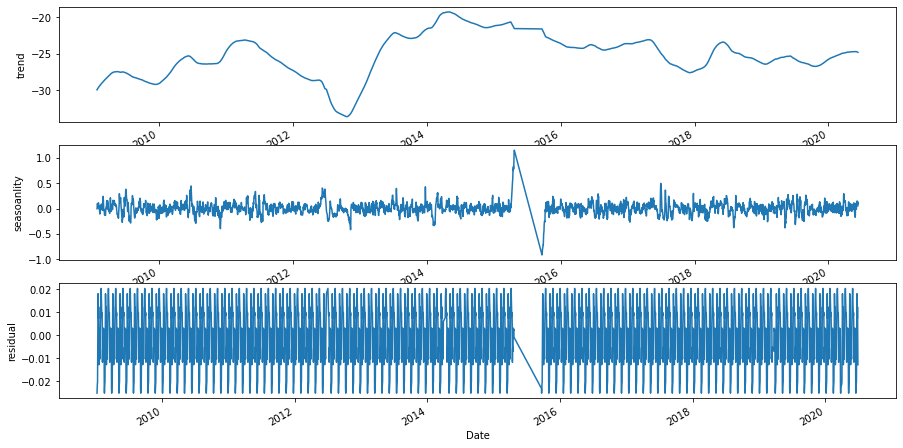

In [57]:
#use additive as multiplicative seasonality is not appropriate for zero and negative values
# decompose_result = seasonal_decompose(Y,model='additive', period=100)
# decompose_result.plot();

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(Y_rf, model = "additive",period = 40)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

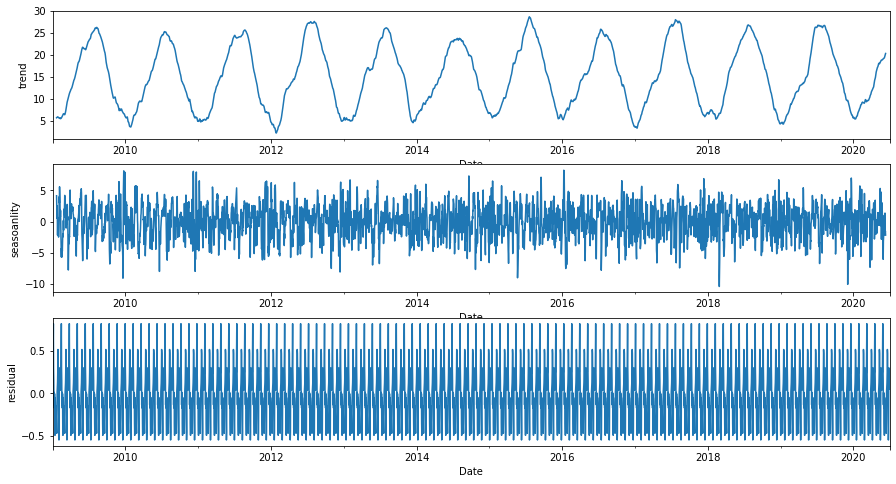

In [58]:
res = seasonal_decompose(df['Temperature_Bastia_Umbra'].dropna(), model = "additive",period = 40)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()

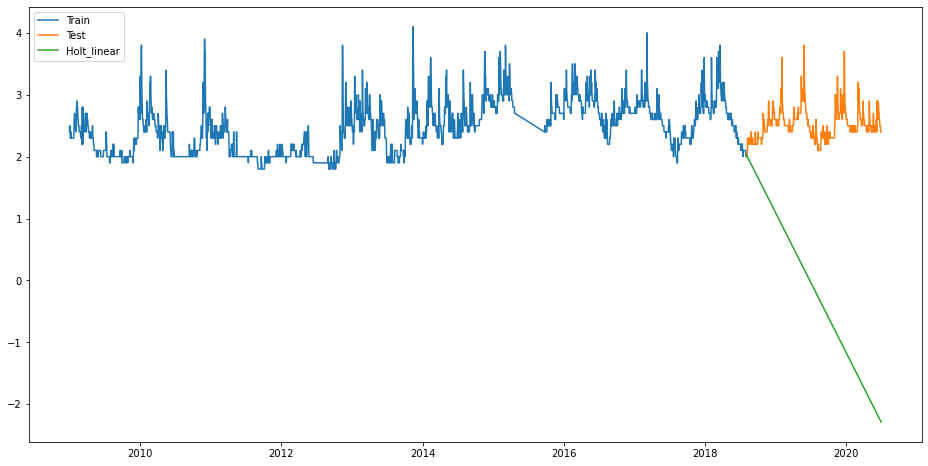

In [59]:
train_hw = pd.DataFrame(index=df['Hydrometry_Fiume_Chiascio_Petrignano'].dropna()[0:3500].index)
test_hw = pd.DataFrame(index=df['Hydrometry_Fiume_Chiascio_Petrignano'].dropna()[3500:].index)
train_hw['temp'] = df['Hydrometry_Fiume_Chiascio_Petrignano'].dropna()[0:3500]
test_hw['temp'] = df['Hydrometry_Fiume_Chiascio_Petrignano'].dropna()[3500:]

y_hat_avg = test_hw.copy()

fit1 = Holt(np.asarray(train_hw['temp'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test_hw))

plt.figure(figsize=(16,8))
plt.plot(train_hw['temp'], label='Train')
plt.plot(test_hw['temp'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()


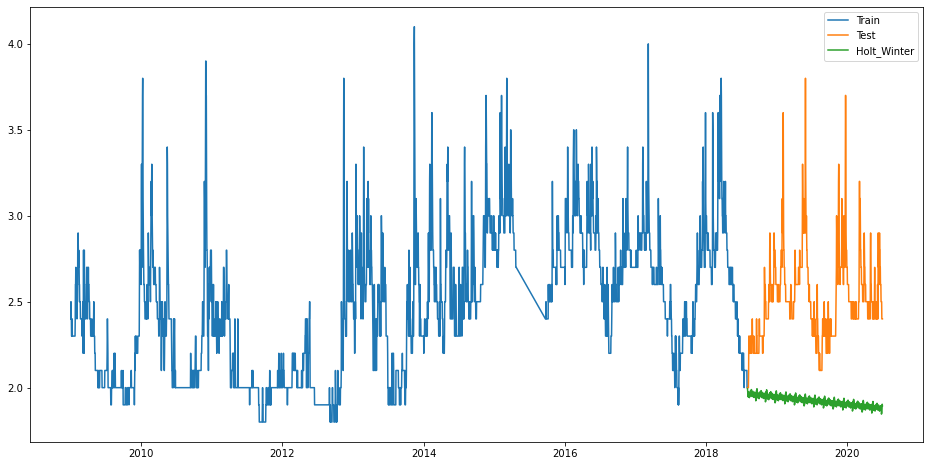

In [60]:
fit1 = ExponentialSmoothing(np.asarray(train_hw['temp']) ,seasonal_periods=50 ,trend='add', seasonal='mul').fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test_hw))

plt.figure(figsize=(16,8))
plt.plot(train_hw['temp'], label='Train')
plt.plot(test_hw['temp'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()


1.Simple Exponential Smoothing
•for a series without trend and seasonality.
2.Holt’s method
•for a series with trend but no seasonality.
3.Winters’ method (or Holt-Winters’ method)
•for a series with seasonality and possibly trend.

## Holt

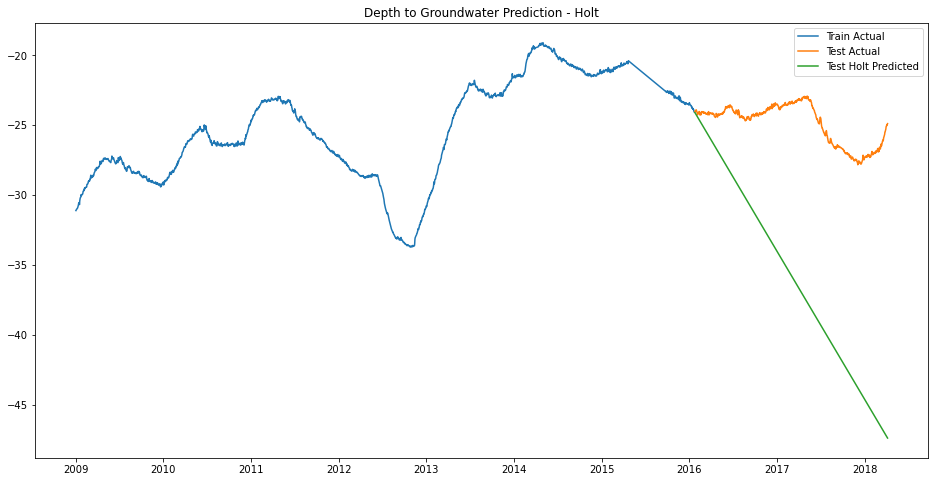

In [61]:
y_hat_avg = y_valid.copy()

holt=Holt(np.asarray(y_train['Depth'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = holt.forecast(len(y_valid))

plt.figure(figsize=(16,8))
plt.plot(y_train['Depth'], label='Train Actual')
plt.plot(y_valid['Depth'], label='Test Actual')
plt.plot(y_hat_avg['Holt_linear'], label='Test Holt Predicted')
plt.title("Depth to Groundwater Prediction - Holt")
plt.legend(loc='best')
plt.show()

In [62]:
X_rf_valid

Rainfall_Bastia_Umbra  Temperature_Bastia_Umbra  \
Date                                                          
2016-01-28                   0.00                      9.70   
2016-01-29                   0.00                      9.50   
2016-01-30                   0.00                     12.00   
2016-01-31                   0.00                     12.80   
2016-02-01                   0.00                     11.10   
...                           ...                       ...   
2018-04-04                  12.80                     13.30   
2018-04-05                   0.00                     12.80   
2018-04-06                   0.00                     13.80   
2018-04-07                   0.00                     15.60   
2018-04-08                  13.60                     13.00   

            Temperature_Petrignano  Volume_C10_Petrignano  \
Date                                                        
2016-01-28                    9.30              -27943.49   
2016-01-29                    9.50              -28785.02   
2016-01-30                   12.00              -27200.45   
2016-01-31                   12.50              -27733.54   
2016-02-01                   10.60              -28026.43   
...                            ...                    ...   
2018-04-04                   12.60              -27501.12   
2018-04-05                   12.80              -28766.88   
2018-04-06                   13.70              -29989.44   
2018-04-07                   15.30              -30489.70   
2018-04-08                   12.90              -26801.28   

            Hydrometry_Fiume_Chiascio_Petrignano  Humidity_Class    year  \
Date                                                                       
2016-01-28                                  2.80           -5.00 2016.00   
2016-01-29                                  2.80           -5.00 2016.00   
2016-01-30                                  2.80           -5.00 2016.00   
2016-01-31                                  2.80           -5.00 2016.00   
2016-02-01                                  2.80           -5.00 2016.00   
...                                          ...             ...     ...   
2018-04-04                                  3.10           -5.00 2018.00   
2018-04-05                                  3.10           -5.00 2018.00   
2018-04-06                                  3.00           -5.00 2018.00   
2018-04-07                                  2.90           -5.00 2018.00   
2018-04-08                                  3.10           -5.00 2018.00   

            month   day  day_of_year  week_of_year  quarter  season  \
Date                                                                  
2016-01-28   1.00 29.00        29.00          4.00     1.00    1.00   
2016-01-29   1.00 30.00        30.00          4.00     1.00    1.00   
2016-01-30   1.00 31.00        31.00          4.00     1.00    1.00   
2016-01-31   2.00  1.00        32.00          5.00     1.00    1.00   
2016-02-01   2.00  2.00        33.00          5.00     1.00    1.00   
...           ...   ...          ...           ...      ...     ...   
2018-04-04   4.00  5.00        95.00         14.00     2.00    2.00   
2018-04-05   4.00  6.00        96.00         14.00     2.00    2.00   
2018-04-06   4.00  7.00        97.00         14.00     2.00    2.00   
2018-04-07   4.00  8.00        98.00         14.00     2.00    2.00   
2018-04-08   4.00  9.00        99.00         15.00     2.00    2.00   

            month_sin  month_cos  day_sin  day_cos  day_of_year_sin  \
Date                                                                  
2016-01-28       0.50       0.87    -0.21     0.98             0.48   
2016-01-29       0.50       0.87    -0.00     1.00             0.49   
2016-01-30       0.50       0.87     0.21     0.98             0.51   
2016-01-31       0.87       0.50     0.21     0.98             0.52   
2016-02-01       0.87       0.50     0.41     0.91         

In [63]:
RMSE_error = mean_squared_error(y_valid.values, y_hat_avg['Holt_linear'], squared=False)
print('Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values, y_hat_avg['Holt_linear'])
print('Test Mean Absolute Error is {}'.format(MAE_error))

Test Root Mean Squared Error is 12.311988037910574
Test Mean Absolute Error is 10.861567720258492


In [64]:
RMSE_error = mean_squared_error(y_valid.values[:30], y_hat_avg['Holt_linear'][:30], squared=False)
print('30 Days Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values[:30], y_hat_avg['Holt_linear'][:30])
print('30 Days Test Mean Absolute Error is {}'.format(MAE_error))

30 Days Test Root Mean Squared Error is 0.4713475666814968
30 Days Test Mean Absolute Error is 0.4226236897924583


In [65]:
print(holt.summary())

                              Holt Model Results                              
Dep. Variable:                  endog   No. Observations:                 2411
Model:                           Holt   SSE                             24.551
Optimized:                       True   AIC                         -11051.395
Trend:                       Additive   BIC                         -11028.244
Seasonal:                        None   AICC                        -11051.360
Seasonal Periods:                None   Date:                 Sat, 03 Apr 2021
Box-Cox:                        False   Time:                         19:03:47
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.3000000                alpha                False
smoothing_trend            0.1000000                

## Holt's Winter

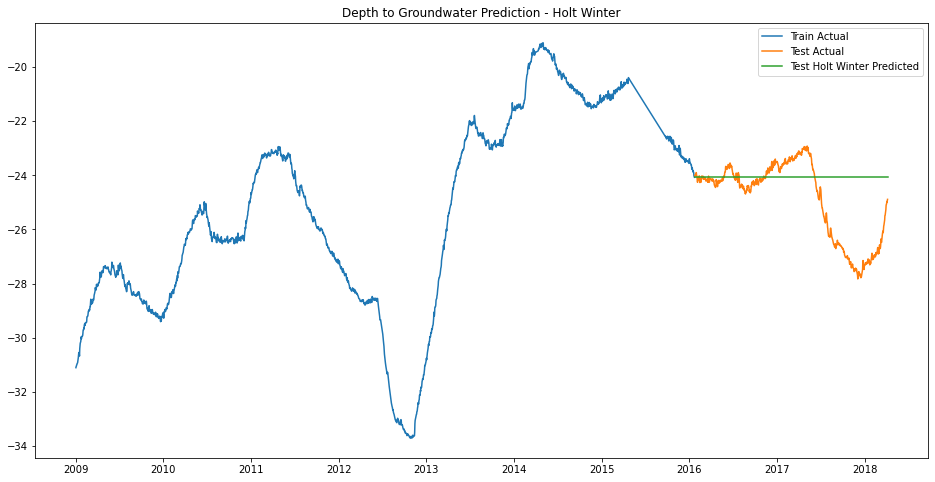

In [66]:

holtWinter=ExponentialSmoothing(np.asarray(y_train['Depth'])).fit()
y_hat_avg['Holt_Winter'] = holtWinter.forecast(len(y_valid))

plt.figure(figsize=(16,8))
plt.plot(y_train['Depth'], label='Train Actual')
plt.plot(y_valid['Depth'], label='Test Actual')
plt.plot(y_hat_avg['Holt_Winter'], label='Test Holt Winter Predicted')
plt.title("Depth to Groundwater Prediction - Holt Winter")
plt.legend(loc='best')
plt.show()

In [67]:
df['Temperature_Bastia_Umbra'].dropna()


Date
2009-01-01    5.20
2009-01-02    2.30
2009-01-03    4.40
2009-01-04    0.80
2009-01-05   -1.90
              ... 
2020-06-26   25.70
2020-06-27   26.20
2020-06-28   26.90
2020-06-29   26.90
2020-06-30   27.30
Name: Temperature_Bastia_Umbra, Length: 4199, dtype: float64

In [68]:
RMSE_error = mean_squared_error(y_valid.values, y_hat_avg['Holt_Winter'], squared=False)
print('Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values, y_hat_avg['Holt_Winter'])
print('Test Mean Absolute Error is {}'.format(MAE_error))

Test Root Mean Squared Error is 1.6496104997103118
Test Mean Absolute Error is 1.1550621890106159


In [69]:
print(holtWinter.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 2411
Model:             ExponentialSmoothing   SSE                             14.263
Optimized:                         True   AIC                         -12364.662
Trend:                             None   BIC                         -12353.086
Seasonal:                          None   AICC                        -12364.645
Seasonal Periods:                  None   Date:                 Sat, 03 Apr 2021
Box-Cox:                          False   Time:                         19:03:50
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
initial_level             -31.1095

# Prophet

In [70]:
from prophet import Prophet
m = Prophet()
prophet_df = y_train['Depth'].reset_index()
prophet_df = prophet_df.rename(columns={"Date": "ds", "Depth": "y"})
m.fit(prophet_df)


In [71]:
future = m.make_future_dataframe(periods=802+803)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds   yhat  yhat_lower  yhat_upper
4011 2020-06-12 -29.85     -114.22       66.84
4012 2020-06-13 -29.83     -114.38       67.03
4013 2020-06-14 -29.83     -114.35       66.98
4014 2020-06-15 -29.85     -114.43       67.12
4015 2020-06-16 -29.88     -114.86       67.26

In [72]:
m = Prophet()
prophet_df = y_train['Depth'].reset_index().append(y_valid['Depth'].reset_index())
prophet_df = prophet_df.rename(columns={"Date": "ds", "Depth": "y"}).reset_index(drop=True).loc[len(prophet_df)-803:].reset_index(drop=True)
m.fit(prophet_df)


In [73]:
prophet_df

ds      y
0   2016-01-26 -23.98
1   2016-01-27 -23.98
2   2016-01-28 -24.01
3   2016-01-29 -23.99
4   2016-01-30 -23.90
..         ...    ...
798 2018-04-03 -25.06
799 2018-04-04 -24.97
800 2018-04-05 -24.99
801 2018-04-06 -24.94
802 2018-04-07 -24.89

[803 rows x 2 columns]

In [74]:
future = m.make_future_dataframe(periods=803)
forecast2 = m.predict(future)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds   yhat  yhat_lower  yhat_upper
1601 2020-06-14 -20.25      -62.96       17.06
1602 2020-06-15 -20.26      -62.93       17.26
1603 2020-06-16 -20.27      -62.98       17.28
1604 2020-06-17 -20.28      -63.18       17.31
1605 2020-06-18 -20.28      -63.14       17.48

In [75]:
val_pred = forecast['yhat'].loc[2411:2411+801].tolist()
test_pred = forecast2['yhat'].loc[len(prophet_df) :].tolist()

rf_val_pred = pd.DataFrame(val_pred, index=y_rf_valid.index)
rf_val_pred.columns=["Val_Predicted"]

rf_test_pred = pd.DataFrame(test_pred, index=y_rf_test.index)
rf_test_pred.columns=["Test_Predicted"]




fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=y_rf_train.index, y=y_rf_train["Depth"], name="Train Actual"))
fig.add_trace(go.Scatter(x=y_rf_valid.index, y=y_rf_valid["Depth"], name="Valid Actual",line=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=y_rf_test.index, y=y_rf_test["Depth"], name="Test Actual",line=dict(color='RoyalBlue')))

fig.add_trace(go.Scatter(x=rf_val_pred.index, y=rf_val_pred.Val_Predicted, name="Valid Predicted",line=dict(color='LightSeaGreen')))
fig.add_trace(go.Scatter(x=rf_test_pred.index, y=rf_test_pred.Test_Predicted, name="Test Predicted",line=dict(color='LightSeaGreen')))

# # Add shapes
fig.add_shape(type="line",
    x0=y_rf_valid.index[0],x1=y_rf_valid.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
fig.add_shape(type="line",
    x0=y_rf_test.index[0],x1=y_rf_test.index[0],y0=-35,y1=-18,
    line=dict(color="MediumPurple",width=3, dash="dot",)
)
# Edit the layout
fig.update_layout(showlegend=True, title="Depth To Groundwater Prophet Predictions",
                           xaxis_title="Date")

fig.show()
plot_to_html("prophetpredict.html",fig)


plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



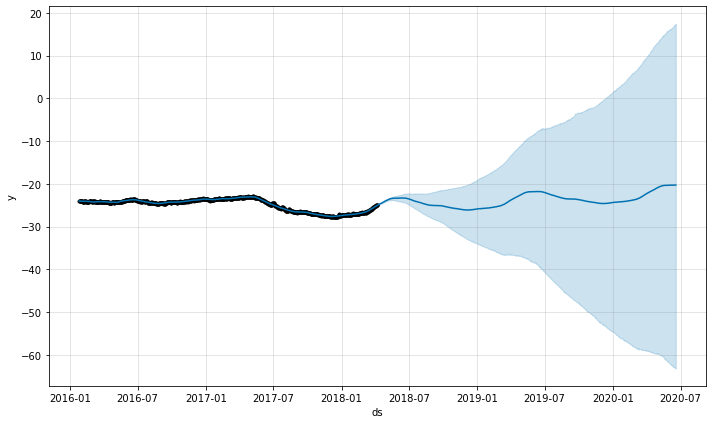

In [76]:
fig1 = m.plot(forecast2)


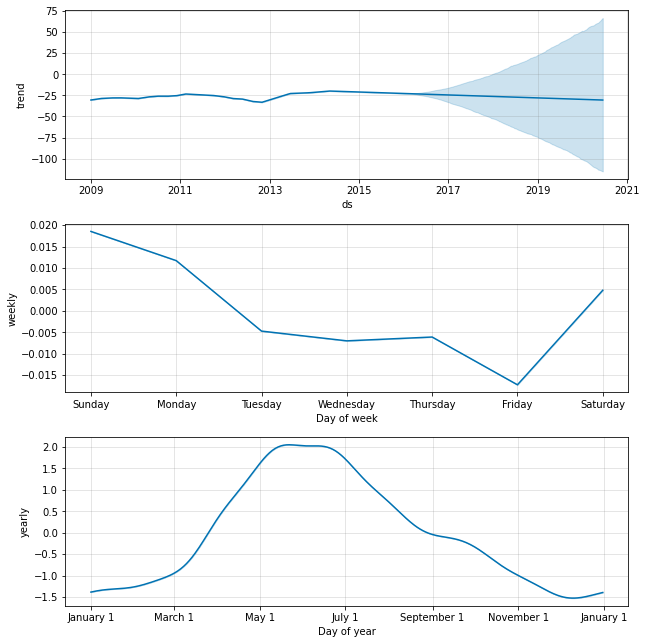

In [77]:
fig2 = m.plot_components(forecast)


In [78]:
from prophet.plot import plot_plotly, plot_components_plotly


plot_to_html("prophet.html",plot_plotly(m, forecast))

In [79]:
plot_to_html("prophet2.html",plot_components_plotly(m, forecast))


## Auto ARIMA

In [80]:
from pmdarima import auto_arima 
model = auto_arima(y_train, stationary=True)               # set to stepwise 
model.fit(y_train)
y_hat_avg['AutoARIMA'] = model.predict(n_periods=len(y_valid))

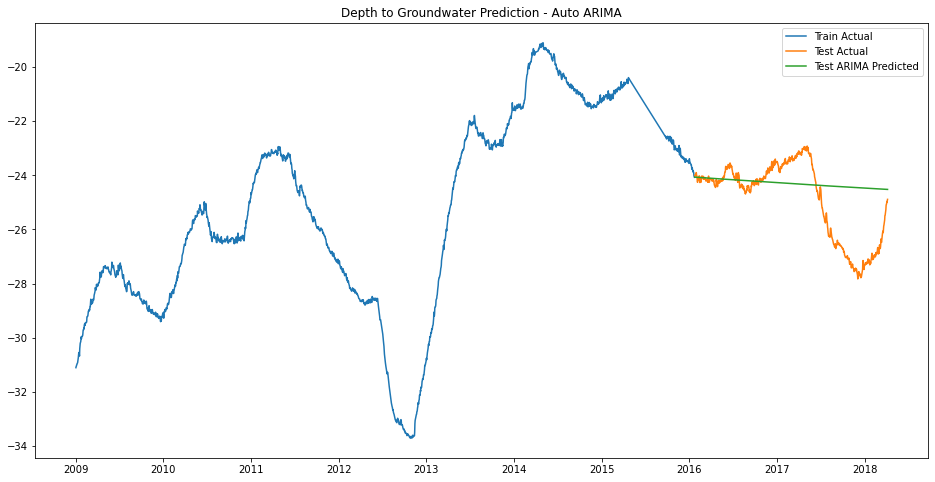

In [81]:
plt.figure(figsize=(16,8))
plt.plot(y_train['Depth'], label='Train Actual')
plt.plot(y_valid['Depth'], label='Test Actual')
plt.plot(y_hat_avg['AutoARIMA'], label='Test ARIMA Predicted')
plt.title("Depth to Groundwater Prediction - Auto ARIMA")
plt.legend(loc='best')
plt.show()

In [82]:
RMSE_error = mean_squared_error(y_valid.values, y_hat_avg['AutoARIMA'], squared=False)
print('Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values, y_hat_avg['AutoARIMA'])
print('Test Mean Absolute Error is {}'.format(MAE_error))

Test Root Mean Squared Error is 1.4671833856048169
Test Mean Absolute Error is 1.0643475245171625


In [83]:
RMSE_error = mean_squared_error(y_valid.values[:30], y_hat_avg['AutoARIMA'][:30], squared=False)
print('30 Days Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values[:30], y_hat_avg['AutoARIMA'][:30])
print('30 Days Test Mean Absolute Error is {}'.format(MAE_error))

30 Days Test Root Mean Squared Error is 0.10052085988336312
30 Days Test Mean Absolute Error is 0.08619218459390426


In [84]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2411
Model:               SARIMAX(2, 0, 2)   Log Likelihood                2791.631
Date:                Sat, 03 Apr 2021   AIC                          -5571.263
Time:                        19:05:09   BIC                          -5536.536
Sample:                             0   HQIC                         -5558.632
                               - 2411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0143      0.030     -0.485      0.627      -0.072       0.044
ar.L1          0.0294      0.050      0.585      0.559      -0.069       0.128
ar.L2          0.9701      0.050     19.316      0.0

In [85]:
valid_model_pred = y_hat_avg['AutoARIMA']
RMSE_error = mean_squared_error(y_valid.values, valid_model_pred, squared=False)
print('Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values, valid_model_pred)
print('Test Mean Absolute Error is {}'.format(MAE_error))

Test Root Mean Squared Error is 1.4671833856048169
Test Mean Absolute Error is 1.0643475245171625


## Auto ARIMA with rolling forecast

In [86]:

# Fit auto_arima function to AirPassengers dataset 
stepwise_fit = auto_arima(y_train, trace = True, 
                          error_action ='ignore',   # we don't want to know if an order does not work 
                          suppress_warnings = True,  # we don't want convergence warnings 
                          stepwise = True)               # set to stepwise 

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-5715.815, Time=3.15 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-4252.759, Time=0.33 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-4679.570, Time=0.19 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-5665.657, Time=0.22 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-5687.559, Time=0.92 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=-5706.305, Time=0.50 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-5704.827, Time=1.68 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-5709.522, Time=3.57 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-5674.736, Time=0.45 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-5713.153, Time=2.76 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=-5712.116, Time=1.05 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-5712.328, Time=3.87 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-5671.065, Time=2.62 sec

Best model:  ARIMA(2,2,2)(0,0,0)[0]          
Total fit time: 21.322 seconds


In [87]:
print(stepwise_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2411
Model:               SARIMAX(2, 2, 2)   Log Likelihood                2862.907
Date:                Sat, 03 Apr 2021   AIC                          -5715.815
Time:                        19:05:32   BIC                          -5686.880
Sample:                             0   HQIC                         -5705.290
                               - 2411                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5226      0.146      3.588      0.000       0.237       0.808
ar.L2         -0.1582      0.015    -10.674      0.000      -0.187      -0.129
ma.L1         -1.4199      0.147     -9.684      0.0

In [88]:
# rolling forecast with arima model 30 days
history = [x for x in y_train.values]
model_predictions = []
N_test_observations = len(y_valid)
steps = 30
for time_point in tqdm(range(N_test_observations)):
    if time_point%steps==0:
        # Fit auto_arima function to AirPassengers dataset 
        model = auto_arima(history, 
                                  error_action ='ignore',   # we don't want to know if an order does not work 
                                  suppress_warnings = True,  # we don't want convergence warnings 
                                  stepwise = True)               # set to stepwise 
        model.fit(history)
        #output=model.get_forecast(steps=30)
        #print(output)
        output = model.predict(n_periods=steps)
        #yhat = output
        #print(output)
        model_predictions.extend(output)
        true_valid_value = y_valid.values[time_point:time_point+steps]
        #print(true_valid_value)
        history.extend(true_valid_value)
        #print('predicted=%f, expected=%f' % (yhat, true_valid_value))
# MSE_error = mean_squared_error(y_valid.values, model_predictions)
# print('Testing Mean Squared Error is {}'.format(MSE_error))

valid_model_pred = model_predictions[:len(y_valid)]
RMSE_error = mean_squared_error(y_valid.values, valid_model_pred, squared=False)
print('Test Root Mean Squared Error is {}'.format(RMSE_error))
MAE_error = mean_absolute_error(y_valid.values, valid_model_pred)
print('Test Mean Absolute Error is {}'.format(MAE_error))

  0%|          | 0/804 [00:00<?, ?it/s]

Test Root Mean Squared Error is 0.3166211799837661
Test Mean Absolute Error is 0.20691065696890848


In [89]:
valid_pred = pd.DataFrame(valid_model_pred, index=y_valid.index)
valid_pred.columns=["Valid_Predicted"]

In [90]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Line(x=y_train.index, y=y_train.Depth, name="Train Actual"))
fig.add_trace(go.Scatter(x=y_valid.index, y=y_valid.Depth, name="Test Actual",line=dict(color='royalblue')))
fig.add_trace(go.Line(x=y_valid.index, y=valid_pred.Valid_Predicted, name="Test Predicted"))
# Edit the layout
fig.update_layout(showlegend=True, title="Depth To Groundwater ARIMA Predictions",
                           xaxis_title="Date")

fig.show()
plot_to_html("bruh3.html",fig)

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.



## ARCH

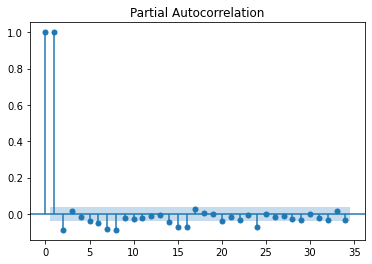

In [91]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
# create acf plot
plot_pacf(y_train.dropna(),)
plt.show()

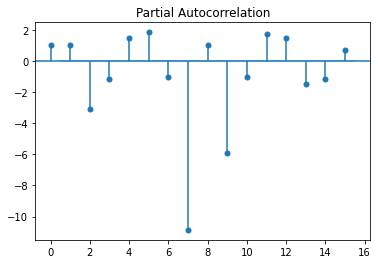

In [92]:
plot_pacf(y_valid, lags=15)
plt.show()

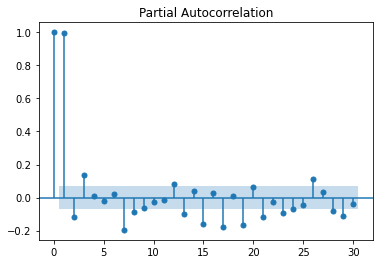

In [93]:
plot_pacf(y_test.dropna())
plt.show()

In [94]:
y_valid

Depth
Date             
2016-01-25 -24.02
2016-01-26 -23.98
2016-01-27 -23.98
2016-01-28 -24.01
2016-01-29 -23.99
...           ...
2018-04-03 -25.06
2018-04-04 -24.97
2018-04-05 -24.99
2018-04-06 -24.94
2018-04-07 -24.89

[804 rows x 1 columns]

In [95]:
from arch import arch_model

def garch(num_days_used, rolling_window):
    # split into train/test
    n_test = int(num_days_used/2)
    Y_garch = Y[-num_days_used:]
    train, test = Y_garch[:-n_test], Y_garch[-n_test:]
    # define model
    model = arch_model(train, vol='GARCH', p=7, q=7)
    # fit model
    model_fit = model.fit()
    # forecast the test set
    yhat = model_fit.forecast(horizon=n_test)
    var=pd.DataFrame()
    var["7 days rolling"]=Y["Depth"].rolling(rolling_window).var()
    # forecast variance
    var_pred = pd.DataFrame(yhat.variance.values[-1, :], index=Y.index[-n_test:])
    var_pred.columns=["Variance_Predicted"]
#     plt.plot(var_pred)
#     plt.xticks(rotation=45)
#     plt.title("Depth to Groundwater Variance Prediction - GARCH")
#     plt.show()
    # plot actual and forecast variance
    plt.plot(var[-num_days_used:], label="Actual variance")
    plt.plot(var_pred, label="Predicted variance")
    plt.title("Depth to Groundwater Variance Prediction - GARCH {} Days Data, {} Days Rolling Variance".format(num_days_used, rolling_window))
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.show()
    plt.plot(var[-n_test:], label="Actual variance")
    plt.plot(var_pred, label="Predicted variance")
    plt.title("Depth to Groundwater Variance Prediction - GARCH Test Set".format(num_days_used, rolling_window))
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.show()

Iteration:      1,   Func. Count:     18,   Neg. LLF: -19.994203496695118
Iteration:      2,   Func. Count:     39,   Neg. LLF: -20.004114801941736
Iteration:      3,   Func. Count:     60,   Neg. LLF: -20.015900053001417
Iteration:      4,   Func. Count:     78,   Neg. LLF: -21.541507016087916
Iteration:      5,   Func. Count:     97,   Neg. LLF: -21.638342109178645
Iteration:      6,   Func. Count:    115,   Neg. LLF: -21.7320637485185
Iteration:      7,   Func. Count:    134,   Neg. LLF: -21.73505509390594
Iteration:      8,   Func. Count:    152,   Neg. LLF: -21.737293366286337
Iteration:      9,   Func. Count:    170,   Neg. LLF: -21.737375040014484
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -21.737375045122178
            Iterations: 9
            Function evaluations: 170
            Gradient evaluations: 9


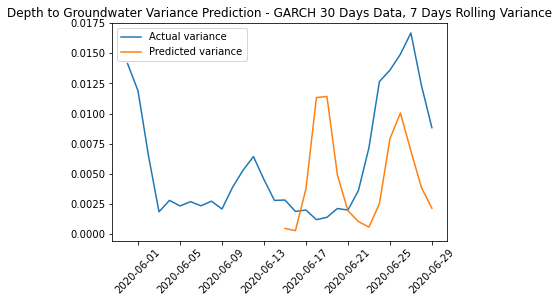

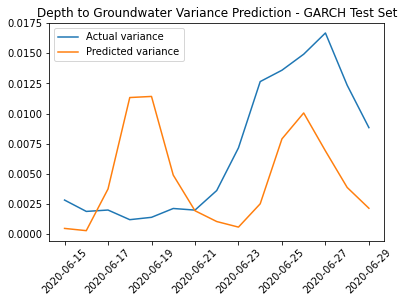

In [96]:
garch(30, 7)

# Operational Analysis

In [111]:
lookback = 10
threshold = 3

In [112]:
def cusum_filter(raw_time_series, threshold, time_stamps=True):
    """
    Identify timestamps where probability distribution of stochastic process deviates from the norm
 
    """
    
    t_events = []
    sides=[]
    s_pos = 0
    s_neg = 0
    
    # Min Max Scaling
    x_scaled = (raw_time_series-raw_time_series.min())/(raw_time_series.max()-raw_time_series.min())
    diff = x_scaled.pct_change()
    
    # Get event time stamps for the entire series
    for i in diff.index[1:]:
        pos = float(s_pos + diff.loc[i])
        neg = float(s_neg + diff.loc[i])
        s_pos = max(0.0, pos)
        s_neg = min(0.0, neg)
        
        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)
            sides.append(-1)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)
            sides.append(1)

    # Return DatetimeIndex or list
    if time_stamps:
        event_timestamps = pd.DatetimeIndex(t_events)
        return event_timestamps

    
    return pd.Series(sides,index=t_events)

def get_vol_and_cusum(data,col,lookback,threshold_fraction=2.0):
    daily_vol = get_daily_vol(close=data[col], lookback=lookback).dropna()
    threshold=daily_vol.mean()*threshold_fraction
    cusum_events = cusum_filter(data[col], threshold=threshold, time_stamps=False)
    return daily_vol,threshold,cusum_events

def show_vol_and_cusum(data,col,lookback,threshold_fraction=2.0):
    daily_vol,threshold,cusum_events=get_vol_and_cusum(data,col, lookback,threshold_fraction)
    daily_vol.plot(figsize=(14,4));
    print(daily_vol.describe())
    print('With threshold','{th:,.6f}'.format(th=threshold),'there are',cusum_events.shape[0], 
      'CUSUM events, or','{percent:,.2%}'.format(percent=float(cusum_events.shape[0]/data.shape[0])))
    
def get_daily_vol(close, lookback=100):
    df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df0 = df0[df0>0]
    df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
    df0 = close.loc[df0.index] / close.loc[df0.values].values - 1
    df0 = df0.ewm(span=lookback).std()
    return df0

def plotcevts(df,cevts,col):
    fig = plt.figure(figsize=(16,8))
    ax = fig.add_subplot(111)
    
    ax.plot(df[col], color='blue', lw=1)
    plus=cevts.index[cevts==1]
    minus=cevts.index[cevts==-1]
    ax.scatter(plus, df[col][plus],color='green')
    ax.scatter(minus, df[col][minus],color='red')
    
    plt.title('CUSUM events - '+ str(threshold))
    plt.show();


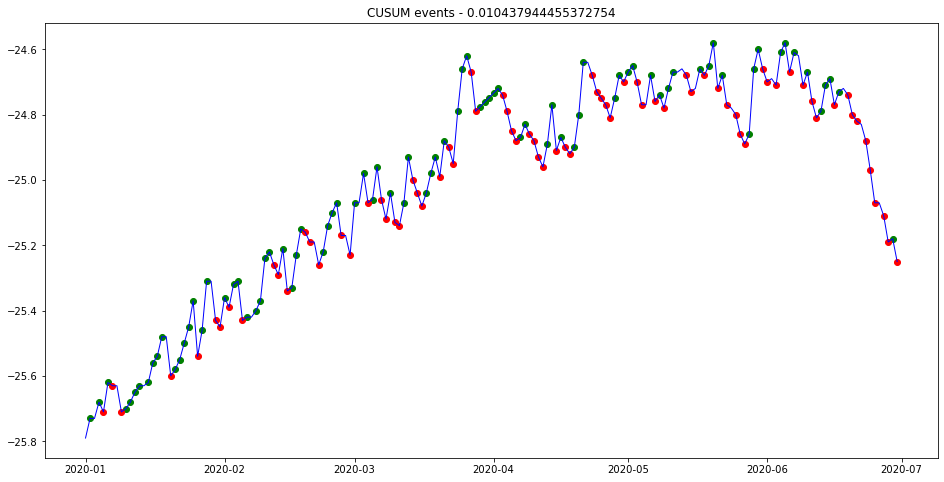

In [113]:
daily_vol,threshold,cusum_events=get_vol_and_cusum(df["2020":],col='Depth_to_Groundwater_P25',lookback=lookback,threshold_fraction=threshold)
plotcevts(df["2020":],cusum_events,col='Depth_to_Groundwater_P25')

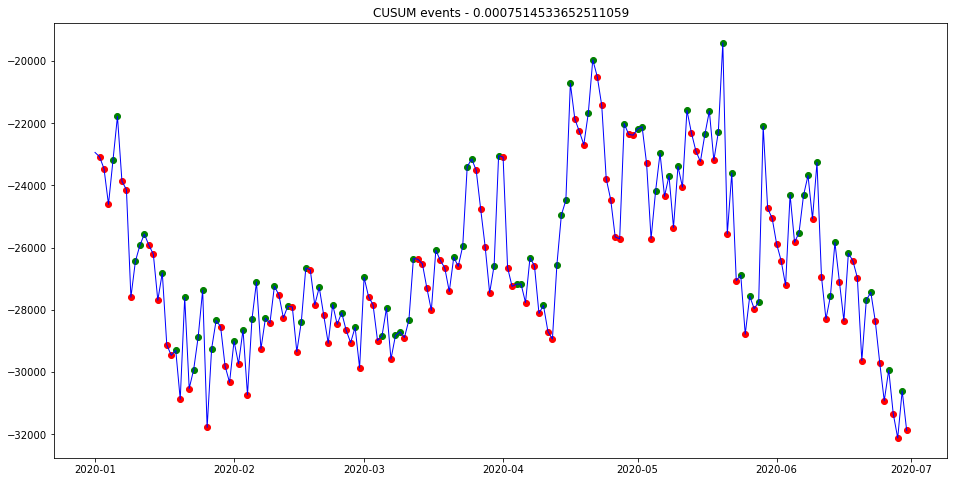

In [114]:
daily_vol,threshold,cusum_events=get_vol_and_cusum(df["2020":],col='Volume_C10_Petrignano',lookback=lookback,threshold_fraction=threshold)
plotcevts(df["2020":],cusum_events,col='Volume_C10_Petrignano')

# Analysing Seasonality

In [115]:
from pandas import read_csv
from statsmodels.tsa.stattools import adfuller
X = df['Depth_to_Groundwater_P25'].dropna().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.160498
p-value: 0.022388
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567


In [116]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df["Depth_to_Groundwater_P25"])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.160497670076592
p-value: 0.022388147805932932
Critical Values:
	1%: -3.431609633182582
	5%: -2.8620966262332583
	10%: -2.5670662920324077


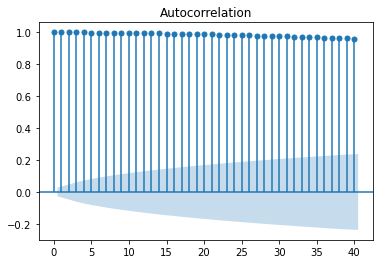

In [117]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df['Depth_to_Groundwater_P25'].dropna().values.squeeze(), lags=40)
plt.show()

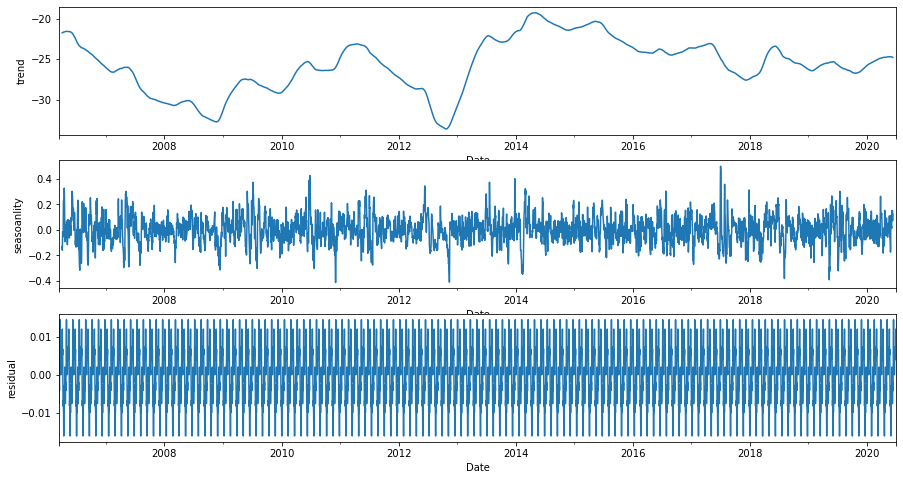

In [118]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df['Depth_to_Groundwater_P25'].dropna(), model = "additive",period = 40)

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,ylabel = "trend")
res.resid.plot(ax=ax2,ylabel = "seasoanlity")
res.seasonal.plot(ax=ax3,ylabel = "residual")
plt.show()